In [170]:
from ipywidgets import interact, FloatSlider, RadioButtons,Dropdown,SelectMultiple,FloatRangeSlider
import gc, argparse, sys, os, errno
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import h5py
import os
import scipy
import sklearn
from scipy.stats import pearsonr
from sklearn.metrics import roc_curve,roc_auc_score
import warnings
warnings.filterwarnings('ignore')
from ipywidgets import interact, FloatSlider,IntSlider, RadioButtons,Dropdown,Tab,Text
styles = ["white","dark",'whitegrid',"darkgrid"]
contexts = ['paper','talk','poster','notebook']
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from  sklearn import preprocessing
from sklearn.metrics import roc_curve, auc
tableau20 = np.array([(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)])/255.

Populating the interactive namespace from numpy and matplotlib


In [2]:
pwd

'/home/chenxupeng/projects/training'

In [4]:
wholeannotation = pd.read_table("wholeannotation.csv",sep=',')
wholeannotation.head()

,Unnamed: 0,Sample_ID,Disease_status,Sex,Age,Tumor_size(cm),Multiple_tumor,Vascular_invasion,Satellite_nonules,AFP(ng/ml),...,PT,Stage-BCLC,RNA_mass(ng/mlplasma),Batch,spike-in,Seq-mode,DNase1,use,sampleuse,Disease_status_formal
0,0,lulab_249136_B,HCC_before_surgery,M,43,2.8,No,No,0,559.6,...,10.1,A,27.63,7th_201803,NaN,NaN,NaN,1,1,HCC
1,1,lulab_385247_B,HCC_before_surgery,M,54,4,No,No,1,19.61,...,12,A,33.45,4th_201801,NaN,NaN,NaN,1,1,HCC
2,2,lulab_423976_B,HCC_before_surgery,F,60,_,No,Yes,0,4.58,...,15,C,32.66,3nd_201801,NaN,NaN,NaN,1,1,HCC
3,3,lulab_497411_B,HCC_before_surgery,F,70,8,No,No,0,3.45,...,11.3,A,28.32,2nd_201712,0,PE150,N,1,1,HCC
4,4,lulab_497497_B,HCC_before_surgery,M,44,12.3,Yes,No,0,3155,...,11.2,B,34.24,1st_201711,0,PE150,N,1,1,HCC


# feature selection
use after normalization

## prepare data
- main and top20
- preprocess

In [5]:
##注意： 经过检验，normalization步骤的sample use是没问题的，在前64个sample中去掉三个sample，这里wholeanno是66个sample，
##在前64个有三个去掉，再去掉post的即为需要的
sampleinduse = np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,14,  15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 58, 59, 60])

In [6]:
np.where(wholeannotation['sampleuse'] ==1)[0][:-2]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63])

#### 需要的43个sample的table！

In [7]:
#需要的43个sample的table！
usetable = wholeannotation.iloc[np.where(wholeannotation['sampleuse'] ==1)[0][:-2]].iloc[sampleinduse]

In [8]:
np.sum(usetable['Disease_status_formal'] =='HCC')

30

In [9]:
def get_data(full=True):
    if full:
        featuretable=  pd.read_table('05.matrix/forfeatureselectionbynorm_61samplefull.csv',sep=',').iloc[:,1:].iloc[sampleinduse,:]
        featuretable['lables'][featuretable['lables'] ==2]=0
        return featuretable
    else:
        featuretable =  pd.read_table('05.matrix/forfeatureselectionbynorm_61samplebinned.csv',sep=',').iloc[:,1:].iloc[sampleinduse,:]
        featuretable['lables'][featuretable['lables'] ==2]=0
        return featuretable
def top20_data(full=True):
    if full:
        return np.array(pd.read_table('05.matrix/forfeatureselectionbynorm_61samplefulltop20.csv',sep=',').iloc[:,1:].iloc[:,sampleinduse]).T
    else:
        return np.array(pd.read_table('05.matrix/forfeatureselectionbynorm_61samplebinnedtop20.csv',sep=',').iloc[:,1:].iloc[:,sampleinduse]).T
def get_concat_data(top20,main):
    main[np.isnan(main)] =0
    print (preprocessing.scale(top20).shape)
    print (preprocessing.scale(main).shape)
    fullfeaturesarray =np.concatenate((preprocessing.scale(main),
                               preprocessing.scale(top20),
                ),axis=1)
    print (fullfeaturesarray.shape)
    return fullfeaturesarray   

In [135]:
fullfeaturename = np.concatenate((get_data(full=True).columns[2:],
                np.array(pd.read_table('05.matrix/forfeatureselectionbynorm_61samplefulltop20.csv',sep=',').iloc[:,0])))
binfeaturename = np.concatenate((get_data(full=False).columns[2:],
                np.array(pd.read_table('05.matrix/forfeatureselectionbynorm_61samplebinnedtop20.csv',sep=',').iloc[:,0])))
mixfeaturename = np.concatenate((fullfeaturename,binfeaturename))

In [137]:
binfeaturenamesplit = np.array([binfeaturename[i].split('__')[0] for i in range(binfeaturename.shape[0])]).astype('object')
mixfeaturenamesplit = np.concatenate((fullfeaturename,binfeaturenamesplit)).astype('object')

In [10]:
fullfeaturesarray = get_concat_data(top20_data(full=True),np.array(get_data(full=True).iloc[:,2:]))
binfeaturesarray = get_concat_data(top20_data(full=False),np.array(get_data(full=False).iloc[:,2:]))

(43, 20)
(43, 25237)
(43, 25257)
(43, 20)
(43, 64237)
(43, 64257)


In [14]:
mixfeaturesarray = np.concatenate((fullfeaturesarray,binfeaturesarray),axis=1)
mixfeaturesarray.shape

(43, 89514)

In [51]:
fullfeaturetable = get_data(full=True)
fullfeaturearray = np.array(fullfeaturetable.iloc[:,2:])
top20full = top20_data(full=True)
top20full.shape

In [621]:
np.array(featuretable['lables']).reshape(1,-1).shape

(1, 43)

### 直接feature selection full fit挑gene！

#### 准备数据供feature selection
- 三种数据格式*(stageA vs control, stageB vs control, stageC vs control, HCC vs control，同时区分三个stage和control)
- 共15种数据
从fullfeaturesarray,binfeaturesarray,mixfeaturesarray加上索引获得
- **目前先做stage A vs normal，HCC vs normal两种**

In [16]:
np.array(usetable['Stage-BCLC'])

array(['A', 'A', 'C', 'A', 'B', 'B', 'B', 'A', 'A', 'B', 'A', 'B', 'A',
       'A', 'B', 'A', 'A', 'C', 'B', 'A', 'B', 'C', 'A', 'B', 'A', 'A',
       'B', 'C', 'A', 'A', '-', '-', '-', '-', '-', '-', '-', '-', '-',
       '-', '-', '-', '-'], dtype=object)

In [17]:
def produce_sample_ind():
    '''
    generate five types of sample ind
    '''
    inda = np.where(usetable['Stage-BCLC'] =='A')[0]
    indb = np.where(usetable['Stage-BCLC'] =='B')[0]
    indc = np.where(usetable['Stage-BCLC'] =='C')[0]
    indnormal = np.where(usetable['Stage-BCLC'] =='-')[0]
    indhcc = np.concatenate((inda,indb,indc))
    return inda,indb,indc,indnormal,indhcc

In [18]:
indA,indB,indC,indnormal,indhcc = produce_sample_ind()

In [19]:
print (indA)
print (indB)
print (indC)
print (indnormal)
print (indhcc)

[ 0  1  3  7  8 10 12 13 15 16 19 22 24 25 28 29]
[ 4  5  6  9 11 14 18 20 23 26]
[ 2 17 21 27]
[30 31 32 33 34 35 36 37 38 39 40 41 42]
[ 0  1  3  7  8 10 12 13 15 16 19 22 24 25 28 29  4  5  6  9 11 14 18 20
 23 26  2 17 21 27]


In [27]:
sampleclass = np.zeros([43]).astype('int') #各种类别的
binaryind = np.zeros([43]).astype('int') #hcc vs normal
binaryind[indhcc] = 1
sampleclass[indA] = 1
sampleclass[indB] = 2
sampleclass[indC] = 3

In [22]:
sampleclass

array([1, 1, 3, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 3, 2, 1, 2, 3,
       1, 2, 1, 1, 2, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [26]:
sampleclass[np.concatenate((indA,indnormal))]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

In [28]:
binaryind[np.concatenate((indhcc,indnormal))]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [211]:
def generate_featurearr(featurekind,featureclass):
    '''
    featurekind: full,bin,mix
    featureclass: A,B,C,hcc(hccvsnormal),all(allkinds)
    '''
    stageindAnorm = np.concatenate((indA,indnormal))
    hccnorm = np.concatenate((indhcc,indnormal))
    if featurekind == 'full':
        if featureclass == 'A':
            return fullfeaturesarray[stageindAnorm],sampleclass[stageindAnorm].astype('int')
        elif featureclass == 'hcc':
            return fullfeaturesarray[hccnorm],binaryind[hccnorm].astype('int')
    elif featurekind =='bin':
        if featureclass == 'A':
            return binfeaturesarray[stageindAnorm],sampleclass[stageindAnorm].astype('int')
        elif featureclass == 'hcc':
            return binfeaturesarray[hccnorm],binaryind[hccnorm]  .astype('int')  
    elif featurekind =='mix':
        if featureclass == 'A':
            return mixfeaturesarray[stageindAnorm],sampleclass[stageindAnorm].astype('int')
        elif featureclass == 'hcc':
            return mixfeaturesarray[hccnorm],binaryind[hccnorm].astype('int')

### 先获得六种feature
以full A为例进行尝试

In [212]:
datatype = ['full','bin','mix']
dataclass = ['A','hcc']
dataset = {}
labelset = {} 
for i in range(3):
    dataset[datatype[i]],labelset[datatype[i]] = {},{}
    for j in range(2):
        dataset[datatype[i]][dataclass[j]],labelset[datatype[i]][dataclass[j]] = generate_featurearr(datatype[i],dataclass[j])

In [213]:
dataset['full']['A']
labelset['full']['A']

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

### 特征选择
- logistic regression 加上L1正则化，画图显示不同正则化参数选出的feature
- MRMR

In [550]:
def logistic_selection(feature,label,penalty=1):
    logmodel = LogisticRegression(penalty='l1',C=penalty)
    logmodel.fit(feature,label)
    return logmodel.coef_.ravel()

In [551]:
binfeaturename[i].split('__')

['miRNA_MIR6859.1', '17429', '17436']

In [554]:
def get_featurename(coef,featurename):
    selectfeatureind = np.where(np.abs(coef)>=0.00001)[0]
    selectfeatureind_ =selectfeatureind[np.argsort(-np.abs(coef[selectfeatureind]))[:np.where(coef!=0)[0].shape[0]]]
    ttttesttab =  pd.DataFrame(np.concatenate((featurename[selectfeatureind_].reshape(-1,1),
                                coef[np.argsort(-np.abs(coef))
                             [:np.where(coef!=0)[0].shape[0]]].reshape(-1,1)),axis=1),
                columns=['ID','importance'])
    countlist_ = []
    for i in range(50):
        countlist_.append(ttttesttab.iloc[i,0]+': '+str(np.round(ttttesttab.iloc[i,1],4)))
    display(pd.DataFrame(np.array(countlist_).reshape(-1,5)))
    fig,ax=plt.subplots(1,figsize=(10,5))
    ax.plot(np.abs(np.array(ttttesttab.iloc[:,1])))
    ax.set_xticks(np.arange(0,ttttesttab.shape[0],5))
    ax.set_title('feature importance: logistic regression L1')
    return ttttesttab

,0,1,2,3,4
0,mRNA_C8orf59: 0.5548,mRNA_HRNR: 0.4675,mRNA_TOM1L1: -0.3236,lncRNA_LINC01715: -0.2878,mRNA_SLC13A1: 0.2794
1,lncRNA_AC093831.2: 0.242,Y_RNA_ENSG00000201084.1: 0.2393,piRNA_piR.hsa.21148_10: 0.2273,lncRNA_AC080080.1: 0.2176,mRNA_SLC51A: -0.2077
2,srpRNA_RN7SL504P: 0.201,piRNA_piR.hsa.1848_2: 0.1892,lncRNA_AC004623.1: -0.1867,mRNA_TRMT10B: 0.1867,mRNA_TLN2: 0.1603
3,mRNA_HSH2D: 0.1555,piRNA_piR.hsa.29477: 0.1517,snRNA_RNU1.30P: 0.1489,mRNA_IL18: 0.1454,mRNA_WDR92: 0.126
4,mRNA_FLYWCH1: -0.1095,mRNA_VCAN: 0.1057,lncRNA_AC015813.1: 0.0932,mRNA_LRRC23: 0.0811,mRNA_PDCD6IP: 0.0712
5,Y_RNA_ENSG00000238783.1: 0.07,mRNA_COL3A1: -0.0664,mRNA_SYBU: 0.0632,mRNA_GPRASP1: 0.0618,Y_RNA_ENSG00000207525.1: 0.0605
6,mRNA_CXorf21: 0.0588,mRNA_SMCO2: -0.0573,tRNA_26898: 0.0513,lncRNA_LINC00273: -0.0457,mRNA_ADAMTS6: 0.0425
7,mRNA_AZI2: 0.0409,lncRNA_CACNA2D3.AS1: -0.0373,lncRNA_AC005072.1: -0.037,mRNA_THBS2: -0.0357,mRNA_CCDC152: -0.0259
8,mRNA_DSN1: 0.0242,lncRNA_AL162511.1: 0.0136,lncRNA_AC120045.1: -0.0118,tRNA_22344: 0.0103,snRNA_RNU4.36P: 0.009
9,lncRNA_LINC00381: -0.0072,mRNA_NBPF12: 0.0067,mRNA_FASTKD2: 0.0064,mRNA_ZNF844: 0.0062,Y_RNA_ENSG00000207401.1: 0.0055


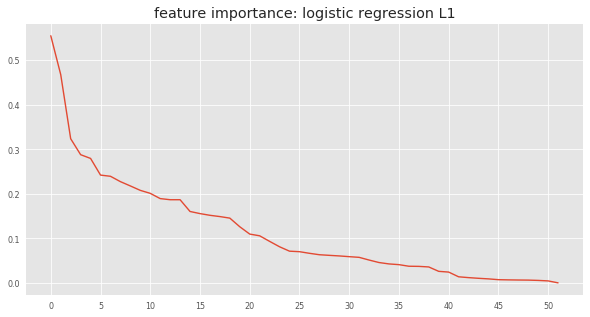

In [556]:
logfullAtable = get_featurename(logistic_selection(dataset['full']['A'],labelset['full']['A'],penalty=2),fullfeaturename)

,0,1,2,3,4
0,piRNA_piR.hsa.2621_68: 0.4584,piRNA_piR.hsa.1848_2: 0.4235,lncRNA_LINC00381: -0.4013,mRNA_AZI2: 0.3434,lncRNA_AC013643.3: 0.3115
1,mRNA_ZNF883: 0.2957,snoRNA_SNORD74B: -0.2458,srpRNA_RN7SL504P: 0.241,mRNA_CCDC136: -0.2389,mRNA_HIST1H2BI: 0.2335
2,mRNA_IL18: 0.2257,mRNA_FASTKD2: 0.2223,mRNA_DMBT1: -0.2184,mRNA_TMC6: 0.208,mRNA_PRIM1: 0.2041
3,snRNA_RNU1.30P: 0.1932,lncRNA_AL359633.2: 0.1854,mRNA_MGAT4A: 0.1853,mRNA_CCS: -0.1672,mRNA_CCDC152: -0.1588
4,piRNA_piR.hsa.21148_10: 0.1376,mRNA_PDCD6IP: 0.1306,mRNA_PMEL: -0.1179,mRNA_CCDC140: 0.1141,mRNA_THBS2: -0.1078
5,snRNA_RNU6.866P: -0.0993,lncRNA_UXT.AS1: 0.0796,miRNA_MIR4477A: 0.0755,lncRNA_CACNA2D3.AS1: -0.0742,mRNA_OR5T2: 0.0723
6,mRNA_CNIH4: 0.0689,mRNA_DSN1: 0.065,lncRNA_FGF14.AS2: 0.0559,mRNA_SMCO2: -0.0556,miRNA_MIR6723: -0.0456
7,tRNA_28805: 0.0442,mRNA_WDR3: 0.0413,mRNA_EPB41L3: 0.04,mRNA_VCAN: 0.0385,lncRNA_AL138921.1: 0.0375
8,mRNA_C17orf58: -0.0351,mRNA_PKD2: 0.0328,piRNA_piR.hsa.30958_24: 0.0325,mRNA_FAM171A2: -0.0324,lncRNA_AC015813.1: 0.032
9,Y_RNA_ENSG00000252784.1: -0.0273,mRNA_TRERF1: 0.0265,mRNA_LCORL: 0.0216,piRNA_piR.hsa.23387_75020: -0.0201,mRNA_TRIM15: 0.0174


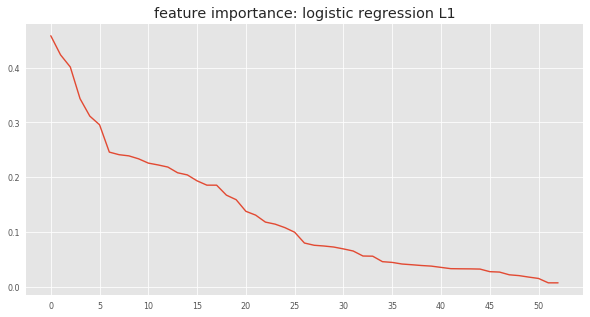

In [557]:
logfullhcctable = get_featurename(logistic_selection(dataset['full']['hcc'],labelset['full']['hcc'],penalty=2),fullfeaturename)

In [130]:
binfeaturenamesplit

array(['miRNA_MIR6859.1', 'miRNA_MIR6859.1', 'miRNA_MIR6859.1', ...,
       'Y_RNA_ENSG00000201778.1', 'Y_RNA_ENSG00000201778.1',
       'Y_RNA_ENSG00000201778.1'], dtype='<U29')

,0,1,2,3,4
0,miRNA_MIR486-2: 0.4227,Y_RNA_ENSG00000201778.1: 0.3503,miRNA_MIR486-2: 0.3232,snoRNA_SNORA2B: 0.2858,Y_RNA_ENSG00000201676.1: 0.2843
1,mRNA_HRG: -0.237,Y_RNA_ENSG00000201676.1: 0.2268,mRNA_OAZ2: -0.2067,mRNA_RPS29: 0.2045,mRNA_ENSG00000137154.12: -0.204
2,mRNA_ENSG00000213741.9: 0.1987,piRNA_piR.hsa.20572_3700: -0.1889,mRNA_FLYWCH1: -0.1652,mRNA_MSL2: -0.1623,snoRNA_SNORD74B: -0.1623
3,lncRNA_AC090340.1: 0.1616,mRNA_RPS6: -0.1574,snoRNA_SNORD74B: -0.1349,lncRNA_AC090340.1: 0.1265,lncRNA_ENSG00000259221.5: 0.1224
4,mRNA_FLYWCH1: -0.1107,mRNA_ENSG00000156508.17: -0.1106,mRNA_HRG: -0.1104,mRNA_ENSG00000137154.12: -0.1089,snoRNA_SNORD74B: -0.1054
5,snoRNA_ENSG00000238835.1: 0.1048,snoRNA_SNORA36C: 0.1029,mRNA_METTL24: 0.1022,mRNA_OAZ2: -0.1008,snoRNA_SNORD74B: -0.0905
6,piRNA_piR.hsa.4048_3: -0.0898,lncRNA_TCL6: -0.0885,snoRNA_SNORD116.18: 0.0877,mRNA_MSL2: -0.0851,mRNA_ASPHD2: 0.085
7,lncRNA_AC090340.1: 0.0845,mRNA_ZNF665: -0.0838,mRNA_HRG: -0.0791,lncRNA_AC090340.1: 0.0791,lncRNA_SNHG20: 0.076
8,lncRNA_AC090340.1: 0.0735,mRNA_RPS29: 0.0731,snoRNA_SNORD116.18: 0.0694,piRNA_piR.hsa.1848_2: 0.0634,snoRNA_SNORA2B: 0.0616
9,piRNA_piR.hsa.20572_3700: -0.0604,mRNA_RPL21: -0.0602,mRNA_EEF1A1: -0.0594,mRNA_SMPD3: 0.0587,miRNA_MIR6781: -0.0586


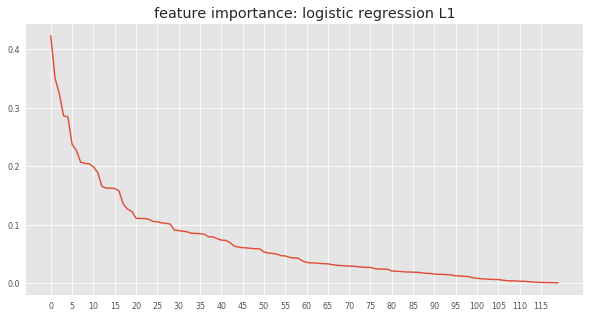

In [558]:
logbinAtable =get_featurename(logistic_selection(dataset['bin']['A'],labelset['bin']['A'],penalty=2),binfeaturenamesplit)

,0,1,2,3,4
0,Y_RNA_ENSG00000201778.1: 0.5213,miRNA_MIR486-2: 0.478,snoRNA_SNORD74B: -0.3804,snoRNA_SNORD74B: -0.3353,snoRNA_SNORD74B: -0.3307
1,miRNA_MIR486-2: 0.2965,snoRNA_SNORD74B: -0.2848,lncRNA_FP236383.2: -0.2741,mRNA_RPS29: 0.2726,srpRNA_RN7SL282P: 0.2475
2,mRNA_RPS29: 0.2267,srpRNA_RN7SL282P: 0.2255,lncRNA_LPP.AS2: 0.2116,snRNA_RNU4.2: 0.1523,miRNA_MIRLET7I: 0.1446
3,lncRNA_PRNCR1: 0.1427,lncRNA_AC090340.1: 0.1266,lncRNA_AC090340.1: 0.1184,lncRNA_AC090340.1: 0.1178,mRNA_ENSG00000213741.9: 0.1176
4,snoRNA_SNORA2B: 0.1136,lncRNA_LPP.AS2: 0.1084,piRNA_piR.hsa.20572_3700: -0.1067,Y_RNA_ENSG00000201676.1: 0.1033,snRNA_RNU4.46P: 0.1024
5,mRNA_EEF1A1: -0.0996,lncRNA_AC006548.3: -0.0965,mRNA_RPS29: 0.0963,piRNA_piR.hsa.1848_2: 0.0936,lncRNA_LPP.AS2: 0.0933
6,lncRNA_AC023905.1: 0.0926,lncRNA_FP236383.2: -0.0922,lncRNA_ENSG00000226711.6: -0.0903,snRNA_RNU4.46P: 0.0871,lncRNA_AC006548.3: 0.0824
7,srpRNA_RN7SL504P: 0.0819,lncRNA_FP236383.2: -0.0817,snoRNA_SNORD116.18: 0.0803,lncRNA_LINC01695: 0.0789,mRNA_YWHAZ: -0.0787
8,lncRNA_AC023905.1: 0.0774,lncRNA_AC006548.3: -0.0771,lncRNA_LINC01695: 0.0765,mRNA_MT.ND5: -0.0758,mRNA_EN1: -0.0722
9,tRNA_36015: 0.0702,miRNA_MIRLET7I: 0.067,snoRNA_SNORA15B.1: 0.0657,lncRNA_AC023905.1: 0.0645,mRNA_ENSG00000156508.17: -0.0644


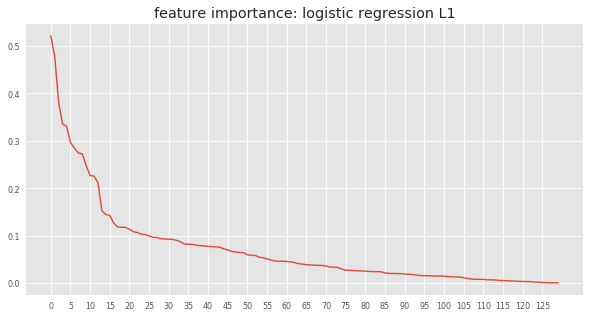

In [559]:
logbinhcctable =get_featurename(logistic_selection(dataset['bin']['hcc'],labelset['bin']['hcc'],penalty=2),binfeaturenamesplit)

,0,1,2,3,4
0,mRNA_C8orf59: 0.3305,lncRNA_AC004623.1: -0.2926,lncRNA_LINC01715: -0.255,mRNA_TAS2R1: 0.19,mRNA_ORC6: 0.1727
1,mRNA_HRNR: 0.1652,mRNA_LRRC23: 0.1621,mRNA_IL18: 0.1557,srpRNA_RN7SL504P: 0.1532,piRNA_piR.hsa.21148_10: 0.1522
2,mRNA_SLC13A1: 0.1488,lncRNA_AL162511.1: 0.1433,snRNA_RNU1.30P: 0.1358,Y_RNA_ENSG00000201084.1: 0.1223,mRNA_TGS1: -0.1203
3,mRNA_TRMT10B: 0.113,tRNA_26898: 0.106,mRNA_WDR92: 0.1027,lncRNA_AC093831.2: 0.0981,mRNA_CCDC152: -0.0952
4,mRNA_ZNF711: 0.0935,mRNA_FASTKD2: 0.0867,lncRNA_AC080080.1: 0.0853,piRNA_piR.hsa.1848_2: 0.0821,mRNA_FLYWCH1: -0.082
5,Y_RNA_ENSG00000238783.1: 0.0819,mRNA_FAM171A2: -0.0772,lncRNA_AC120045.1: -0.0751,lncRNA_LINC02418: -0.0719,mRNA_ADAMTS6: 0.0712
6,mRNA_THBS2: -0.0712,mRNA_IQANK1: 0.0703,mRNA_DDX25: 0.07,piRNA_piR.hsa.21148_30: 0.0697,mRNA_VCAN: 0.0661
7,mRNA_BORCS6: 0.0648,mRNA_NBPF12: 0.063,mRNA_SLC51A: -0.0626,mRNA_UPRT: 0.0605,mRNA_SMCO2: -0.0602
8,mRNA_CNOT6L: 0.0585,mRNA_CGREF1: -0.0584,lncRNA_CACNA2D3.AS1: -0.058,lncRNA_LINC00381: -0.0522,tRNA_30791: 0.052
9,mRNA_TTC7A: 0.0507,mRNA_ZNF35: 0.0445,mRNA_GPRASP1: 0.044,mRNA_ZNF737: 0.043,mRNA_FLYWCH1: -0.0424


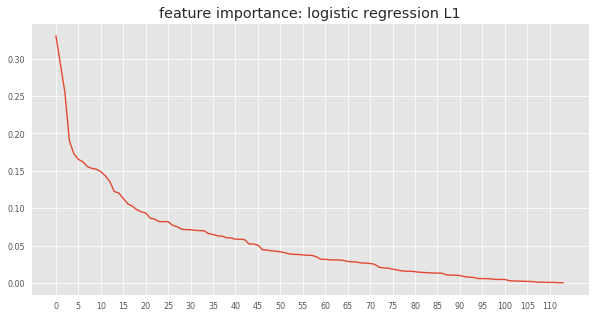

In [560]:
logmixAtable = get_featurename(logistic_selection(dataset['mix']['A'],labelset['mix']['A'],penalty=2),mixfeaturenamesplit)

,0,1,2,3,4
0,lncRNA_LINC00381: -0.3534,mRNA_AZI2: 0.3279,piRNA_piR.hsa.2621_68: 0.3155,srpRNA_RN7SL504P: 0.3115,lncRNA_AC013643.3: 0.2668
1,mRNA_CCS: -0.2637,snoRNA_SNORD74B: -0.2453,piRNA_piR.hsa.21148_10: 0.2357,snRNA_RNU1.30P: 0.2249,mRNA_ZNF883: 0.2131
2,piRNA_piR.hsa.1848_2: 0.1932,snRNA_RNU6.866P: -0.1778,mRNA_TMC6: 0.1678,lncRNA_AL359633.2: 0.1637,mRNA_SMCO2: -0.1561
3,mRNA_RPS29: 0.1545,mRNA_HIST1H2BI: 0.1521,mRNA_DMBT1: -0.1469,mRNA_IL18: 0.1449,mRNA_CCDC136: -0.1408
4,mRNA_PRIM1: 0.1372,piRNA_piR.hsa.21148_67: 0.126,lncRNA_PAPPA.AS1: 0.1192,lncRNA_CACNA2D3.AS1: -0.1167,tRNA_28805: 0.102
5,mRNA_PMEL: -0.0965,lncRNA_AC080080.1: 0.0955,mRNA_CCDC152: -0.0907,mRNA_FASTKD2: 0.0851,srpRNA_RN7SL504P: 0.085
6,mRNA_TRIM15: 0.0778,mRNA_DSN1: 0.0768,mRNA_CNIH4: 0.0749,mRNA_OR5T2: 0.0724,mRNA_FAM171A2: -0.0683
7,mRNA_MGAT4A: 0.066,mRNA_PKD2: 0.0588,mRNA_THBS2: -0.0566,mRNA_WDR3: 0.0564,srpRNA_RN7SL282P: 0.0542
8,mRNA_GABRB2: 0.0495,mRNA_PDCD6IP: 0.0449,mRNA_ENSG00000213741.9: 0.043,mRNA_TRERF1: 0.0382,lncRNA_AL021408.1: 0.0375
9,lncRNA_AC091180.3: -0.0373,piRNA_piR.hsa.23387_88002: -0.0371,lncRNA_UXT.AS1: 0.0359,mRNA_MYL5: -0.0326,mRNA_SLC32A1: 0.0309


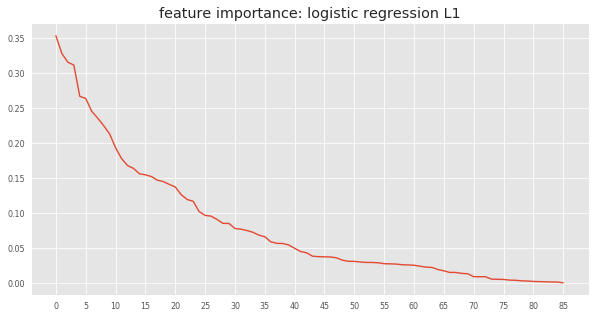

In [561]:
logmixhcctable = get_featurename(logistic_selection(dataset['mix']['hcc'],labelset['mix']['hcc'],penalty=2),mixfeaturenamesplit)

##### 基于树的特征选择

In [333]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
#基于树模型进行模型选择


In [349]:
def get_feature_ind_tree(feature,label):
    clf = ExtraTreesClassifier()
    clf = clf.fit(feature,label)
#特征重要性(数值越高特征越重要)
    return clf.feature_importances_

In [562]:
def get_featurename_tree(coef,featurename):
    selectfeatureind = np.where(np.abs(coef)>=0.00001)[0]
    selectfeatureind_ =selectfeatureind[np.argsort(-np.abs(coef[selectfeatureind]))[:np.where(coef!=0)[0].shape[0]]]
    ttttesttab =  pd.DataFrame(np.concatenate((featurename[selectfeatureind_].reshape(-1,1),
                                coef[np.argsort(-np.abs(coef))
                             [:np.where(coef!=0)[0].shape[0]]].reshape(-1,1)),axis=1),
                columns=['ID','importance'])
    countlist_ = []
    if selectfeatureind.shape[0] >=50:
        for i in range(50):
            countlist_.append(ttttesttab.iloc[i,0]+': '+str(np.round(ttttesttab.iloc[i,1],4)))
        display(pd.DataFrame(np.array(countlist_).reshape(-1,5)))
        fig,ax=plt.subplots(1,figsize=(10,5))
        ax.plot(np.abs(np.array(ttttesttab.iloc[:,1])))
        ax.set_xticks(np.arange(0,ttttesttab.shape[0],5))
        ax.set_title('feature importance: Tree based feature selection')
    else:
        numtmp = selectfeatureind.shape[0]
        numtmp_ = numtmp/5*5
        for i in range(numtmp_):
            countlist_.append(ttttesttab.iloc[i,0]+': '+str(np.round(ttttesttab.iloc[i,1],4)))
        display(pd.DataFrame(np.array(countlist_).reshape(-1,5)))
        fig,ax=plt.subplots(1,figsize=(numtmp/5,5))
        ax.plot(np.abs(np.array(ttttesttab.iloc[:,1])))
        ax.set_xticks(np.arange(0,ttttesttab.shape[0],5))
        ax.set_title('feature importance: Tree based feature selection')
    return ttttesttab

,0,1,2,3,4
0,mRNA_ZNF711: 0.0429,Y_RNA_ENSG00000206739.1: 0.0384,mRNA_SRP72: 0.038,mRNA_LIG4: 0.0285,piRNA_piR.hsa.23387_4612: 0.028
1,mRNA_MKKS: 0.027,mRNA_RBFOX2: 0.0263,mRNA_MCM2: 0.0263,mRNA_TUBB2B: 0.0263,mRNA_OSBPL1A: 0.0258
2,mRNA_CHRNA3: 0.0258,Y_RNA_ENSG00000201084.1: 0.0246,snRNA_RNU6.32P: 0.024,mRNA_FLYWCH1: 0.0236,tRNA_31874: 0.023
3,lncRNA_LINC00337: 0.0228,mRNA_UFM1: 0.0223,mRNA_SHF: 0.0218,mRNA_GSKIP: 0.0217,mRNA_PPTC7: 0.0215
4,mRNA_GRIK4: 0.0213,mRNA_PRIM1: 0.0207,snoRNA_SNORD72: 0.0206,Y_RNA_ENSG00000252319.1: 0.0199,mRNA_SLC41A3: 0.0197
5,mRNA_LCA5: 0.0197,mRNA_ANKRA2: 0.0179,mRNA_NHS: 0.0176,lncRNA_AC106739.1: 0.0175,lncRNA_AC025031.5: 0.0174
6,lncRNA_AC074011.1: 0.0167,mRNA_LARP4B: 0.0157,mRNA_ENSG00000178605.13_PAR_Y: 0.0157,lncRNA_AC131009.2: 0.0151,mRNA_GAB1: 0.013
7,mRNA_MAP1LC3A: 0.013,mRNA_ABRA: 0.013,lncRNA_AC097382.1: 0.0129,mRNA_TMEM248: 0.0129,Y_RNA_ENSG00000200553.1: 0.0124
8,srpRNA_RN7SL320P: 0.0124,snoRNA_SNORA36B: 0.0122,mRNA_PTER: 0.012,srpRNA_RN7SL18P: 0.0112,mRNA_SNX10: 0.0112
9,lncRNA_TERC: 0.0105,mRNA_DIAPH3: 0.0105,tRNA_31484: 0.0105,mRNA_RCCD1: 0.0105,mRNA_DCAF13: 0.0093


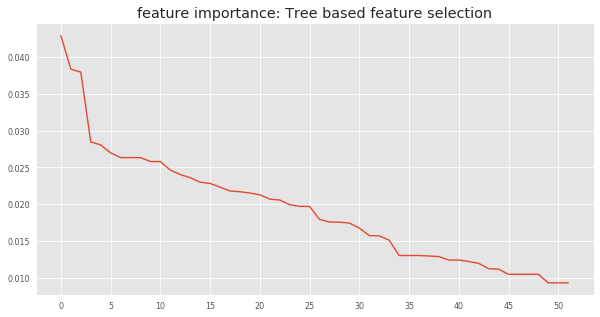

In [563]:
treefullAtable = get_featurename_tree(get_feature_ind_tree(dataset['full']['A'],labelset['full']['A']),fullfeaturename)

,0,1,2,3,4
0,mRNA_RFX7: 0.0356,mRNA_RHOQ: 0.0315,mRNA_P3H2: 0.0287,tRNA_12975: 0.028,lncRNA_AC026320.1: 0.0263
1,lncRNA_HOXC.AS2: 0.024,mRNA_CRTC1: 0.0237,lncRNA_LINC01909: 0.0221,lncRNA_AC007036.2: 0.0217,lncRNA_AC092718.2: 0.0217
2,Y_RNA_ENSG00000201555.1: 0.0212,mRNA_STAP2: 0.0206,mRNA_TMEM165: 0.0204,lncRNA_AC068733.1: 0.0203,mRNA_YIPF6: 0.0191
3,lncRNA_AC104561.3: 0.0187,piRNA_piR.hsa.21008: 0.0182,mRNA_ETS2: 0.018,mRNA_HNRNPH3: 0.0177,lncRNA_AC139256.1: 0.0176
4,mRNA_PTPRQ: 0.0176,Y_RNA_ENSG00000202385.1: 0.0176,mRNA_EHBP1L1: 0.0173,lncRNA_AL359693.1: 0.0173,mRNA_PAFAH1B1: 0.0173
5,lncRNA_AL162574.2: 0.0172,mRNA_PRUNE1: 0.017,miRNA_MIR584: 0.0169,mRNA_NOL6: 0.0167,mRNA_NDUFB3: 0.0165
6,mRNA_POLQ: 0.0163,mRNA_SLC13A1: 0.0162,lncRNA_LINC01443: 0.0155,mRNA_TK2: 0.015,mRNA_RTF1: 0.0147
7,lncRNA_AC069281.2: 0.0147,mRNA_DMBT1: 0.0145,tRNA_13041: 0.0143,lncRNA_LINC01502: 0.0142,mRNA_POLR3D: 0.0132
8,mRNA_PNKD: 0.0131,lncRNA_AC020907.2: 0.0125,mRNA_RCBTB2: 0.0119,mRNA_GXYLT1: 0.0107,mRNA_RAB11B: 0.0107
9,mRNA_AMY1A: 0.0105,mRNA_ADSS: 0.0105,mRNA_SF3A2: 0.0105,lncRNA_AC011270.2: 0.0103,mRNA_SPESP1: 0.0097


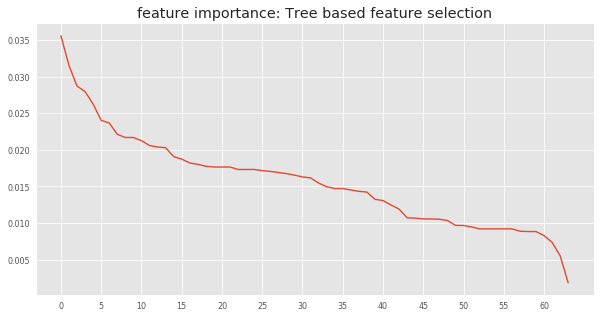

In [564]:
treefullhcctable = get_featurename_tree(get_feature_ind_tree(dataset['full']['hcc'],labelset['full']['hcc']),fullfeaturename)

,0,1,2,3,4
0,piRNA_piR.hsa.20572_3700: 0.0392,mRNA_EMC10: 0.0352,piRNA_piR.hsa.20572_3700: 0.0321,piRNA_piR.hsa.20572_3700: 0.028,lncRNA_PWRN1: 0.0272
1,mRNA_RPS6: 0.0267,lncRNA_AL356275.1: 0.0266,piRNA_piR.hsa.20572_3700: 0.0256,piRNA_piR.hsa.20572_3700: 0.0256,lncRNA_PWRN1: 0.0228
2,mRNA_ENSG00000087470.17: 0.0225,mRNA_KRT8: 0.0217,lncRNA_AC018892.3: 0.0215,mRNA_ENSG00000197249.13: 0.0215,lncRNA_AC009041.2: 0.0215
3,mRNA_MTRNR2L6: 0.0195,miRNA_MIRLET7I: 0.0186,miRNA_MIR26A2: 0.0186,mRNA_ENSG00000100599.15: 0.0181,mRNA_NCOA4: 0.0181
4,snoRNA_SNORA10: 0.0177,snoRNA_SNORA73B: 0.0174,lncRNA_AL157938.3: 0.0168,mRNA_SLC14A1: 0.0167,mRNA_ENSG00000068796.16: 0.0167
5,mRNA_HDAC9: 0.0158,Y_RNA_ENSG00000201208.1: 0.0149,lncRNA_HELLPAR: 0.0145,lncRNA_ENSG00000226674.8: 0.0142,miRNA_MIR451A: 0.0139
6,miRNA_MIR148A: 0.0139,miRNA_MIRLET7I: 0.0139,miRNA_MIR1275: 0.0137,mRNA_ENSG00000167900.11: 0.0131,lncRNA_HELLPAR: 0.013
7,piRNA_piR.hsa.20572_3700: 0.0127,mRNA_SNX29: 0.0125,Y_RNA_ENSG00000207039.1: 0.0125,mRNA_ENSG00000156508.17: 0.0122,mRNA_ENSG00000141376.22: 0.012
8,mRNA_MMS22L: 0.012,mRNA_GSTM2: 0.0119,miRNA_MIR486-2: 0.0116,mRNA_MAP3K7CL: 0.0112,miRNA_MIR21: 0.0109
9,miRNA_MIR4421: 0.0105,mRNA_ENSG00000163631.16: 0.0105,mRNA_PF4V1: 0.0105,miRNA_MIR196A1: 0.01,snoRNA_ENSG00000200999.1: 0.0094


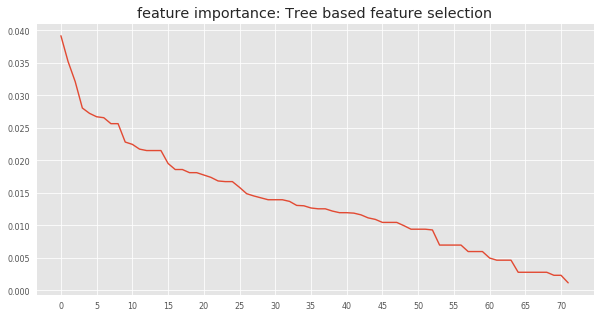

In [565]:
treebinAtable = get_featurename_tree(get_feature_ind_tree(dataset['bin']['A'],labelset['bin']['A']),binfeaturenamesplit)

,0,1,2,3,4
0,srpRNA_RN7SL504P: 0.0376,mRNA_ENSG00000161671.16: 0.0287,miRNA_MIR486-2: 0.0261,lncRNA_AC107983.2: 0.0248,miRNA_MIR1273F: 0.0237
1,piRNA_piR.hsa.20572_3700: 0.0217,piRNA_piR.hsa.20572_3700: 0.0217,lncRNA_ENSG00000224048.5: 0.0214,lncRNA_AL031587.6: 0.0195,mRNA_ENSG00000144524.17: 0.019
2,lncRNA_AC051619.8: 0.0186,mRNA_MBD3: 0.0184,miRNA_MIR451A: 0.0184,mRNA_ACTB: 0.0182,mRNA_ENSG00000022355.16: 0.018
3,piRNA_piR.hsa.20572_3700: 0.0166,piRNA_piR.hsa.20572_3700: 0.016,miRNA_MIR21: 0.016,mRNA_ENSG00000156508.17: 0.016,mRNA_ZNF865: 0.0158
4,mRNA_ENSG00000089157.15: 0.0158,piRNA_piR.hsa.20572_3700: 0.0156,piRNA_piR.hsa.20572_3700: 0.0156,mRNA_ENSG00000101608.12: 0.015,mRNA_ENSG00000116560.10: 0.015
5,mRNA_ENSG00000007372.21: 0.0149,miRNA_MIR4804: 0.0147,mRNA_RPL37A: 0.0147,miRNA_MIR26A1: 0.0141,mRNA_RTL10: 0.0141
6,snoRNA_SNORD116.18: 0.014,mRNA_FBXL17: 0.0136,lncRNA_SERPINB9P1: 0.0134,snoRNA_SNORD116.23: 0.0134,miRNA_MIR10B: 0.0132
7,mRNA_CNPY2: 0.0131,lncRNA_ENSG00000226674.8: 0.0129,piRNA_piR.hsa.20572_3700: 0.0127,miRNA_MIR26A2: 0.0123,snoRNA_SNORA49: 0.0118
8,miRNA_MIR26A2: 0.0118,mRNA_ELMSAN1: 0.0115,lncRNA_AC023905.1: 0.0115,mRNA_ENSG00000127314.17: 0.0111,mRNA_ENSG00000151276.23: 0.0109
9,mRNA_ENSG00000125691.12: 0.0107,mRNA_ENSG00000171561.4: 0.0105,lncRNA_AC009133.1: 0.0103,mRNA_CAVIN2: 0.0099,mRNA_ENSG00000206172.8: 0.0099


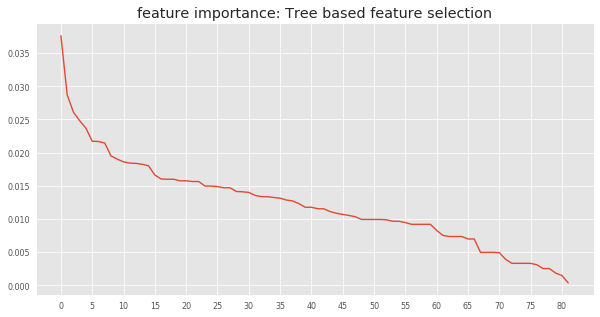

In [566]:
treebinhcctable = get_featurename_tree(get_feature_ind_tree(dataset['bin']['hcc'],labelset['bin']['hcc']),binfeaturenamesplit)

,0,1,2,3,4
0,srpRNA_RN7SL811P: 0.0392,mRNA_ENSG00000111640.14: 0.0373,mRNA_EMC10: 0.0352,Y_RNA_ENSG00000238783.1: 0.0338,tRNA_21363: 0.029
1,piRNA_piR.hsa.20572_3700: 0.028,mRNA_TLN2: 0.028,mRNA_WBP1: 0.0267,mRNA_RORA: 0.0256,piRNA_piR.hsa.20572_3700: 0.0256
2,lncRNA_AC022387.1: 0.0256,lncRNA_AC087516.1: 0.0251,mRNA_TNFRSF14: 0.0249,lncRNA_ENSG00000245526.10: 0.0249,lncRNA_LINC01239: 0.0239
3,mRNA_SFPQ: 0.0234,lncRNA_AC006548.3: 0.0228,lncRNA_XIST: 0.0223,mRNA_LENG8: 0.0217,srpRNA_RN7SL507P: 0.0215
4,piRNA_piR.hsa.20572_3700: 0.0212,piRNA_piR.hsa.27399_2: 0.021,mRNA_ANP32A: 0.0209,mRNA_ARF3: 0.0195,piRNA_piR.hsa.20572_3700: 0.0188
5,lncRNA_LINC01864: 0.0186,mRNA_ENSG00000163631.16: 0.0178,snRNA_RNU6.866P: 0.0171,mRNA_NTM: 0.0166,lncRNA_LINC00273: 0.0146
6,mRNA_SOD2: 0.0139,piRNA_piR.hsa.13252_3: 0.013,mRNA_CCDC138: 0.0129,mRNA_TIMP2: 0.0128,mRNA_ENSG00000089157.15: 0.0127
7,mRNA_SYT9: 0.0127,mRNA_HMCN2: 0.0127,lncRNA_AC103843.1: 0.0122,lncRNA_AC013549.3: 0.0122,lncRNA_TCL6: 0.0122
8,lncRNA_AC009948.5: 0.012,mRNA_TINAGL1: 0.0116,srpRNA_RN7SL778P: 0.0115,lncRNA_AC092184.1: 0.0114,piRNA_piR.hsa.23566_4: 0.0114
9,mRNA_ENSG00000176788.8: 0.0112,mRNA_ENSG00000144524.17: 0.011,mRNA_RGS17: 0.0105,lncRNA_AL627309.5: 0.0105,lncRNA_LINC01140: 0.0093


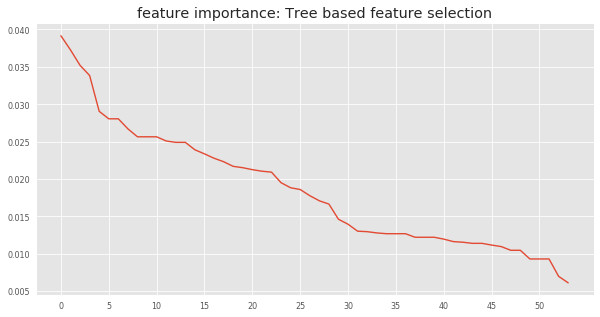

In [567]:
treemixAtable = get_featurename_tree(get_feature_ind_tree(dataset['mix']['A'],labelset['mix']['A']),mixfeaturenamesplit)

,0,1,2,3,4
0,lncRNA_AC004893.2: 0.0284,piRNA_piR.hsa.20572_3700: 0.0284,mRNA_DRC7: 0.0265,mRNA_CCAR1: 0.0262,piRNA_piR.hsa.20572_3700: 0.0232
1,mRNA_ENSG00000164924.17: 0.0221,lncRNA_PSMA3.AS1: 0.0221,snRNA_RNU6.358P: 0.0221,lncRNA_AL137786.1: 0.0217,mRNA_CNR1: 0.0207
2,mRNA_SNAPC3: 0.0204,lncRNA_AC007333.2: 0.0202,mRNA_TTLL10: 0.02,lncRNA_AL356859.1: 0.0194,lncRNA_ENSG00000226674.8: 0.0192
3,mRNA_TTL: 0.0191,piRNA_piR.hsa.20572_3700: 0.0191,lncRNA_NEAT1: 0.0189,mRNA_CORO7: 0.0184,lncRNA_ENSG00000226674.8: 0.0184
4,snRNA_RNU4.46P: 0.0184,piRNA_piR.hsa.1848_2: 0.0182,mRNA_IGSF10: 0.0176,tRNA_28109: 0.0175,mRNA_SORBS3: 0.0173
5,mRNA_ISCU: 0.0173,piRNA_piR.hsa.20572_3700: 0.0173,mRNA_DNAJC6: 0.0173,lncRNA_AC008543.3: 0.0173,lncRNA_AL121672.2: 0.0165
6,mRNA_ENSG00000112096.16: 0.0165,mRNA_GMPPB: 0.0165,mRNA_THEMIS: 0.0158,mRNA_ENSG00000129559.12: 0.0157,mRNA_ENSG00000272869.5: 0.0148
7,mRNA_TAOK3: 0.0147,mRNA_ENSG00000161671.16: 0.0147,mRNA_PTCH2: 0.0146,snRNA_RNU1.8P: 0.0142,lncRNA_EGFR.AS1: 0.0141
8,mRNA_PLEKHA1: 0.0134,mRNA_ENSG00000173698.17: 0.0132,mRNA_ABCB11: 0.0123,mRNA_FAM173B: 0.0122,lncRNA_ADAMTS9.AS2: 0.012
9,miRNA_MIR374A: 0.0116,lncRNA_LINC02290: 0.011,mRNA_ENSG00000156265.15: 0.0106,piRNA_piR.hsa.2153: 0.0098,lncRNA_ENSG00000236830.6: 0.0096


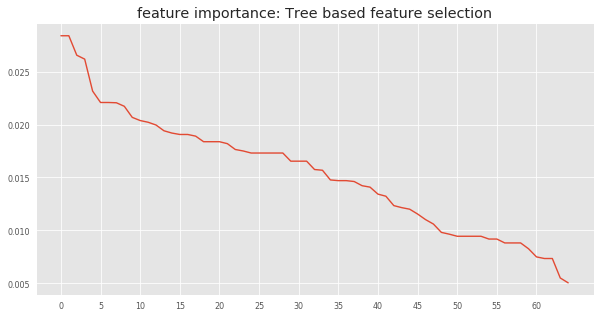

In [568]:
treemixhcctable = get_featurename_tree(get_feature_ind_tree(dataset['mix']['hcc'],labelset['mix']['hcc']),mixfeaturenamesplit)

#### MRMR

##### 准备csv文件
先用差异表达选前一万！
/Share/home/caojingyi/exRNA/process/18.new_hcc_lulab/06.DE/edgeR.result
- HCC_HD+HBV.edgeR.result
- stageA_HD+HBV.edgeR.result

##### 利用方差选特征

##### DE first 10000、5000

In [430]:
def get_de_top_name(num,datatype='full',dataclass='hcc'):
    if datatype=='bin':
        if dataclass=='hcc':
            return pd.read_table('/Share/home/caojingyi/exRNA/process/18.new_hcc_lulab/06.DE/0.name/edgeR.result/HCC_HD+HBV.edgeR.result')['genes'][:num]
        elif dataclass =='stageA':
            return pd.read_table('/Share/home/caojingyi/exRNA/process/18.new_hcc_lulab/06.DE/0.name/edgeR.result/stageA_HD+HBV.edgeR.result')['genes'][:num]
    elif datatype=='full':
        if dataclass=='hcc':
            return pd.read_table('/Share/home/caojingyi/exRNA/process/18.new_hcc_lulab/06.DE/1.name_full/HCC_HD+HBV.edgeR.result')['genes'][:num]
        elif dataclass =='stageA':
            return pd.read_table('/Share/home/caojingyi/exRNA/process/18.new_hcc_lulab/06.DE/1.name_full/stageA_HD+HBV.edgeR.result')['genes'][:num]

In [288]:
np.where(np.array(get_de_top_name(10000,datatype='bin',dataclass='hcc'))==np.array(get_de_top_name(10000,datatype='bin',dataclass='hcc')))

(array([   0,    1,    2, ..., 9997, 9998, 9999]),)

In [281]:
np.sum(np.isin(binfeaturename,np.array(get_de_top_name(10000,datatype='bin',dataclass='hcc'))))

8494

In [421]:
np.arange(0,binfeaturename.shape[0])[np.isin(binfeaturename,np.array(get_de_top_name(10000,datatype='bin',
                                                                                     dataclass='hcc')))]

array([   44,    45,    54, ..., 64030, 64031, 64032])

In [376]:
dataset[datatype[i]][dataclass[j]][:,index].shape

(43, 89514)

In [441]:
def extract_feature_after_de(i,j,extractnum):
    '''
    i = 0,1 extractnum=9900
    i=2 extractnum=4950
    '''
    dattype=['full','bin','mix']
    clastype=['hcc','stageA']
    if i <2:
        toparr = np.array(get_de_top_name(extractnum,datatype=dattype[i],dataclass=clastype[j]))
    elif i==2:
        toparr = np.concatenate((np.array(get_de_top_name(extractnum,datatype=dattype[0],dataclass=clastype[j])),
                                np.array(get_de_top_name(extractnum,datatype=dattype[1],dataclass=clastype[j]))))
    if dattype[i] =='full':
        originarr = fullfeaturename
    elif dattype[i] =='bin':
        originarr = binfeaturename
    elif dattype[i] =='mix':
        originarr = mixfeaturename
    index = np.arange(0,originarr.shape[0])[np.isin(originarr,toparr)]
    return dataset[datatype[i]][dataclass[j]][:,index],index

In [ ]:
#注意六种数据的index和dataset都不一样

In [459]:
datafromde = {}
for i in range(2):
    datafromde[i] = {}
    for j in range(2):
        datafromde[i][j] = extract_feature_after_de(i,j,10000)[0]
for i in [2]:
    datafromde[i] = {}
    for j in range(2):
        datafromde[i][j] = extract_feature_after_de(i,j,5000)[0]

In [491]:
np.sum(np.isin(namefromde[0][0], namefromde[0][1]))

4229

array([    2,     3,     4, ..., 25254, 25255, 25256])

In [485]:
dataset[datatype[0]][dataclass[0]].shape

(29, 25257)

In [486]:
dataset[datatype[0]][dataclass[1]].shape

(43, 25257)

In [483]:
dataset[datatype[0]][dataclass[0]][:,namefromde[0][1]].shape

(29, 4229)

In [434]:
def savefeature_tocsv(i,j):
    dataclass= ['hcc','A']
    tmpdataframe= pd.DataFrame(np.concatenate((labelset[datatype[i]][dataclass[j]].reshape(-1,1).astype('int'),
                             datafromde[i][j]),axis=1),
             columns=np.concatenate((np.array(['class']),
                                     np.array(['v'+str(i) for i in np.arange(1,1+datafromde[i][j].shape[1])]))))
    tmpdataframe.iloc[:,0] = tmpdataframe.iloc[:,0].astype('int')
    tmpdataframe.to_csv('featurecsv/'+datatype[i]+dataclass[j]+'.csv')

In [497]:
dataclass

['A', 'hcc']

In [435]:
for i in range(3):
    for j in range(2):
        savefeature_tocsv(i,j)

MRMR 使用

	 -i <dataset>    maxmum variable:10000
	 -t <threshold> a float number of the discretization threshold; non-specifying this parameter means no discretizaton (i.e. data is already integer); 0 to make binarization.
	 -n <number of features>   a natural number, default is 50.
	 -m <selection method>    either "MID" or "MIQ" (Capital case), default is MID.
	 -s <MAX number of samples>   a natural number, default is 1000. Note that if you don't have or don't need big memory, set this value small, as this program will use this value to pre-allocate memory in data file reading.
	 -v <MAX number of variables/attibutes in data>   a natural number, default is 10000. Note that if you don't have or don't need big memory, set this value small, as this program will use this value to pre-allocate memory in data file reading.
	 [-h] print this message.

In [ ]:
./mrmr -i featurecsv/fullhcc.csv -m MID -n 100 -t 0.5 >featurecsv/fullhcc.out
./mrmr -i featurecsv/fullA.csv -m MID -n 100 -t 0.5 >mrmrout/fullA.out
./mrmr -i featurecsv/binhcc.csv -m MID -n 100 -t 0.5 >mrmrout/binhcc.out
./mrmr -i featurecsv/binA.csv -m MID -n 100 -t 0.5 >mrmrout/binA.out
./mrmr -i featurecsv/mixhcc.csv -m MID -n 100 -t 0.5 >mrmrout/mixhcc.out
./mrmr -i featurecsv/mixA.csv -m MID -n 100 -t 0.5 >mrmrout/mixA.out

In [460]:
namefromde = {}
for i in range(2):
    namefromde[i] = {}
    for j in range(2):
        namefromde[i][j] = extract_feature_after_de(i,j,10000)[1]
for i in [2]:
    namefromde[i] = {}
    for j in range(2):
        namefromde[i][j] = extract_feature_after_de(i,j,5000)[1]

In [444]:
fullfeaturename[namefromde[0][0]]

array(['miRNA_MIR6723', 'miRNA_MIR200B', 'miRNA_MIR200A', ...,
       'miRNA_MIRLET7B', 'miRNA_MIRLET7F2', 'Y_RNA_ENSG00000201778.1'],
      dtype=object)

In [503]:
dattype=['full','bin','mix']
clastype=['hcc','A']
indfrommrmr = {}
coeffrommrmr = {}
for i in range(3):
    indfrommrmr[i],coeffrommrmr[i] = {},{}
    for j in range(2):
        indfrommrmr[i][j] = np.loadtxt('mrmrout/'+dattype[i]+clastype[j]+'.out.txt',dtype='str')[1:,1].astype('int')
        coeffrommrmr[i][j] = np.loadtxt('mrmrout/'+dattype[i]+clastype[j]+'.out.txt',dtype='str')[1:,3].astype('float')

In [569]:
def get_featurename_mrmr(name,coef):
    
    ttttesttab =  pd.DataFrame(np.concatenate((name.reshape(-1,1),
                                coef.reshape(-1,1)),axis=1),
                columns=['ID','importance'])
    countlist_ = []
    if selectfeatureind.shape[0] >=50:
        for i in range(50):
            countlist_.append(ttttesttab.iloc[i,0]+': '+str(np.round(ttttesttab.iloc[i,1],4)))
        display(pd.DataFrame(np.array(countlist_).reshape(-1,5)))
        fig,ax=plt.subplots(1,figsize=(10,5))
        ax.plot(np.abs(np.array(ttttesttab.iloc[:,1])))
        ax.set_xticks(np.arange(0,ttttesttab.shape[0],5))
        ax.set_title('feature importance: DE and MRMR combined selection')
    else:
        numtmp = selectfeatureind.shape[0]
        numtmp_ = numtmp/5*5
        for i in range(numtmp_):
            countlist_.append(ttttesttab.iloc[i,0]+': '+str(np.round(ttttesttab.iloc[i,1],4)))
        display(pd.DataFrame(np.array(countlist_).reshape(-1,5)))
        fig,ax=plt.subplots(1,figsize=(numtmp/5,5))
        ax.plot(np.abs(np.array(ttttesttab.iloc[:,1])))
        ax.set_xticks(np.arange(0,ttttesttab.shape[0],5))
        ax.set_title('feature importance: MRMR Score')
    return ttttesttab

,0,1,2,3,4
0,mRNA_CCT5: 1.583,lncRNA_AC006548.3: 1.575,mRNA_STS: 1.569,mRNA_FAM92B: 1.554,mRNA_UCN3: 1.54
1,lncRNA_AC011603.2: 1.529,miRNA_MIR154: 1.525,lncRNA_AP001496.2: 1.517,mRNA_NAP1L4: 1.508,lncRNA_AC092894.1: 1.509
2,mRNA_HACD3: 1.501,mRNA_KMT2C: 1.506,mRNA_IRF2BP2: 1.498,mRNA_RPS23: 1.498,mRNA_ZBTB20: 1.496
3,mRNA_SNF8: 1.498,mRNA_B4GALNT2: 1.495,mRNA_SMAP1: 1.494,mRNA_IER2: 1.492,mRNA_ATG13: 1.494
4,mRNA_CLIC4: 1.488,mRNA_BHLHE41: 1.488,mRNA_PIEZO1: 1.485,mRNA_FTL: 1.485,mRNA_NADK: 1.484
5,mRNA_S100A10: 1.486,lncRNA_AL023875.1: 1.486,miRNA_MIR26A1: 1.484,mRNA_MBD3: 1.484,lncRNA_AC004817.3: 1.484
6,lncRNA_AC020907.3: 1.483,lncRNA_ENSG00000227540.1: 1.482,mRNA_CFAP97: 1.484,mRNA_ARF3: 1.482,snoRNA_ENSG00000238835.1: 1.48
7,mRNA_RHOB: 1.48,mRNA_SLC11A2: 1.482,lncRNA_AC022558.2: 1.481,lncRNA_AC103702.2: 1.475,mRNA_ITGB8: 1.475
8,mRNA_ZNF286B: 1.475,snoRNA_SCARNA12: 1.477,mRNA_PYROXD1: 1.477,mRNA_KIDINS220: 1.477,lncRNA_AC245297.3: 1.474
9,mRNA_EMP1: 1.476,lncRNA_AP003175.1: 1.475,mRNA_HBA2: 1.475,mRNA_ZNF215: 1.475,mRNA_HNRNPL: 1.476


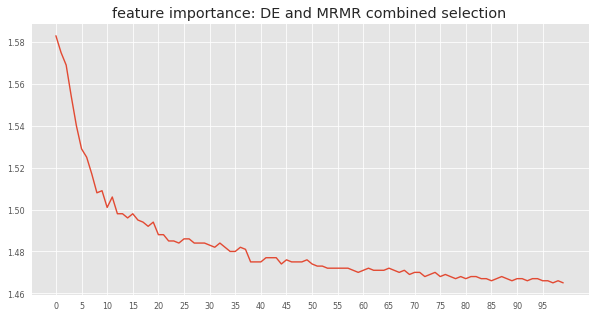

In [570]:
mrmrfullhcctable = get_featurename_mrmr(fullfeaturename[namefromde[0][0]][indfrommrmr[0][0]],coeffrommrmr[0][0])

,0,1,2,3,4
0,mRNA_TLE4: 1.584,snoRNA_SNORD42B: 1.573,mRNA_OAZ1: 1.567,lncRNA_AC005253.1: 1.547,miRNA_MIR30C2: 1.541
1,lncRNA_FTX: 1.537,mRNA_KDM7A: 1.533,mRNA_RICTOR: 1.538,mRNA_ACBD3: 1.529,mRNA_RUNX3: 1.522
2,snoRNA_SCARNA12: 1.527,mRNA_ETV6: 1.522,miRNA_MIR548AU: 1.523,mRNA_PPIAL4G: 1.52,mRNA_IPO7: 1.518
3,mRNA_FAM107A: 1.517,mRNA_ATRX: 1.514,mRNA_ASH1L: 1.51,mRNA_CBS: 1.51,snoRNA_ENSG00000200320.1: 1.512
4,mRNA_RNF11: 1.51,mRNA_S100A8: 1.511,lncRNA_AL033381.1: 1.508,miRNA_MIR548Y: 1.509,mRNA_CYP4F3: 1.51
5,mRNA_XRCC5: 1.509,mRNA_FOXN3: 1.508,srpRNA_RN7SL832P: 1.508,mRNA_DSG2: 1.508,mRNA_RPL13A: 1.506
6,miRNA_MIR141: 1.507,mRNA_RPS14: 1.506,miRNA_MIR641: 1.505,mRNA_RARG: 1.504,mRNA_HSPA9: 1.504
7,mRNA_SMPD3: 1.504,mRNA_EIF5B: 1.504,miRNA_MIR4419A: 1.504,miRNA_MIR548Z: 1.505,mRNA_MARF1: 1.504
8,mRNA_RAB7A: 1.504,lncRNA_LINC02227: 1.503,lncRNA_AP001496.2: 1.502,lncRNA_AL031282.2: 1.502,mRNA_ITGA3: 1.503
9,mRNA_PPM1N: 1.501,mRNA_CACNA1G: 1.502,miRNA_MIR22: 1.502,mRNA_RPS23: 1.502,mRNA_RPL22: 1.5


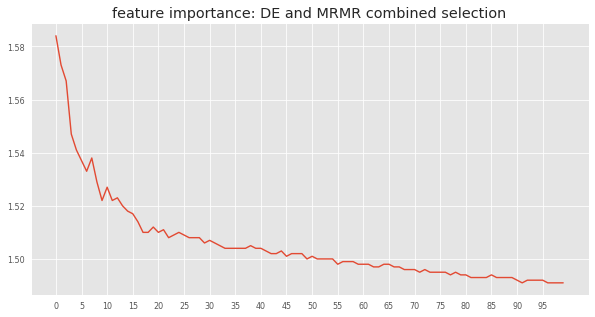

In [571]:
mrmrfullAtable = get_featurename_mrmr(fullfeaturename[namefromde[0][1]][indfrommrmr[0][1]],coeffrommrmr[0][1])

,0,1,2,3,4
0,mRNA_MMS22L: 1.584,lncRNA_ENSG00000234741.7: 1.546,lncRNA_LINC01232: 1.515,mRNA_ENSG00000127314.17: 1.439,lncRNA_AL445490.1: 1.433
1,mRNA_ENSG00000127314.17: 1.417,lncRNA_GAS5: 1.41,mRNA_ENSG00000119801.12: 1.392,mRNA_ENSG00000148484.17: 1.383,lncRNA_ENSG00000234741.7: 1.391
2,mRNA_ENSG00000112096.16: 1.389,mRNA_ENSG00000156265.15: 1.381,lncRNA_AL031430.1: 1.379,lncRNA_LINC01427: 1.377,snoRNA_SNORD72: 1.367
3,mRNA_ENSG00000127314.17: 1.37,mRNA_ENSG00000033170.16: 1.364,snoRNA_ENSG00000209702.1: 1.365,mRNA_ENSG00000163631.16: 1.363,lncRNA_LINC01427: 1.365
4,lncRNA_AP000542.2: 1.364,snoRNA_ENSG00000221066.1: 1.368,mRNA_FTH1: 1.349,lncRNA_GAS5: 1.354,mRNA_ENSG00000148484.17: 1.355
5,snoRNA_SNORD74B: 1.352,lncRNA_AC116351.1: 1.356,lncRNA_LINC01427: 1.35,snoRNA_ENSG00000207493.1: 1.353,mRNA_ENSG00000148484.17: 1.353
6,lncRNA_LINC01427: 1.35,lncRNA_GAS5: 1.343,mRNA_RSPRY1: 1.342,lncRNA_AL360270.2: 1.341,lncRNA_AC006548.3: 1.344
7,mRNA_MMS22L: 1.341,lncRNA_COLCA1: 1.343,snoRNA_SNORD12B: 1.345,mRNA_ENSG00000166710.17: 1.342,lncRNA_LINC00506: 1.337
8,snRNA_RNU12: 1.341,mRNA_ENSG00000033170.16: 1.343,lncRNA_ENSG00000255717.6: 1.338,lncRNA_GAS5: 1.341,mRNA_ENSG00000119801.12: 1.339
9,snoRNA_SNORA73A: 1.338,mRNA_ENSG00000163631.16: 1.338,mRNA_RAP1B: 1.338,lncRNA_AC006548.3: 1.336,lncRNA_ENSG00000234741.7: 1.335


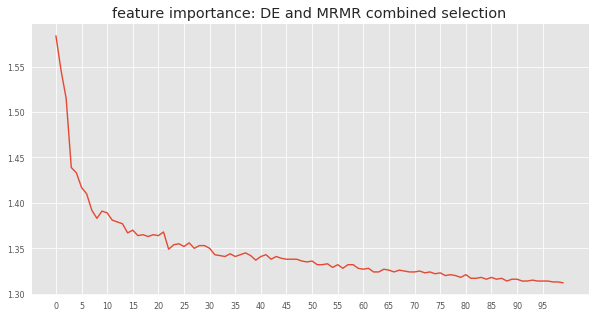

In [572]:
mrmrbinhcctable = get_featurename_mrmr(binfeaturenamesplit[namefromde[1][0]][indfrommrmr[1][0]],coeffrommrmr[1][0])

,0,1,2,3,4
0,lncRNA_HELLPAR: 1.583,snoRNA_SNORD49B: 1.558,mRNA_B2M: 1.55,lncRNA_AC079341.1: 1.45,snoRNA_SNORA50C: 1.443
1,lncRNA_AC016588.2: 1.448,snoRNA_ENSG00000206885.1: 1.437,lncRNA_AC079341.1: 1.431,mRNA_EXOC6: 1.42,lncRNA_LINC00506: 1.41
2,snoRNA_SNORA7B: 1.417,mRNA_C12orf65: 1.408,snoRNA_SNORD124: 1.41,mRNA_CCL5: 1.412,mRNA_GLIPR1: 1.398
3,mRNA_ENSG00000110169.10: 1.401,lncRNA_AC073263.2: 1.397,mRNA_OST4: 1.396,lncRNA_AL671511.1: 1.396,snoRNA_SCARNA10: 1.404
4,snoRNA_ENSG00000238942.1: 1.388,lncRNA_HELLPAR: 1.391,lncRNA_LINC00506: 1.395,lncRNA_AC007743.1: 1.387,snoRNA_ENSG00000238942.1: 1.39
5,mRNA_ENSG00000127314.17: 1.379,snoRNA_SNORD88C: 1.379,mRNA_ENSG00000166710.17: 1.377,snoRNA_ENSG00000222345.1: 1.365,mRNA_RPL4: 1.363
6,lncRNA_AL671511.1: 1.368,lncRNA_LINC00506: 1.364,snoRNA_SNORA11B: 1.365,lncRNA_HELLPAR: 1.368,mRNA_ENSG00000138190.16: 1.37
7,mRNA_GLIPR1: 1.357,lncRNA_ENSG00000242086.8: 1.362,snoRNA_SNORA50: 1.364,snoRNA_SNORD18A: 1.357,lncRNA_AC116351.1: 1.358
8,lncRNA_AC073263.2: 1.358,mRNA_ENSG00000127314.17: 1.357,mRNA_ENSG00000156265.15: 1.357,mRNA_ENSG00000143797.11: 1.358,mRNA_CCL5: 1.359
9,lncRNA_LINC00506: 1.357,snoRNA_ENSG00000238942.1: 1.353,snoRNA_SNORD17: 1.356,snoRNA_ENSG00000265185.5: 1.352,lncRNA_AC245060.6: 1.352


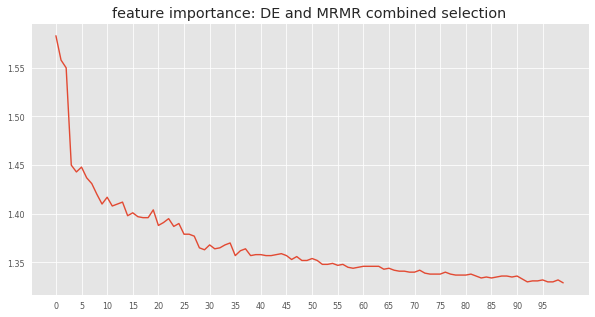

In [573]:
mrmrbinAtable = get_featurename_mrmr(binfeaturenamesplit[namefromde[1][1]][indfrommrmr[1][1]],coeffrommrmr[1][1])

,0,1,2,3,4
0,lncRNA_AC079341.1: 1.583,mRNA_STAT1: 1.575,lncRNA_AC007336.1: 1.558,lncRNA_AC116667.1: 1.554,lncRNA_AC008440.2: 1.539
1,mRNA_ZNF224: 1.527,lncRNA_AC006548.3: 1.513,snoRNA_ENSG00000238835.1: 1.508,mRNA_GLYR1: 1.51,mRNA_PHOSPHO1: 1.506
2,miRNA_MIR1291: 1.504,lncRNA_LINC01305: 1.505,mRNA_SMAD2: 1.503,mRNA_ITGA1: 1.495,mRNA_CHD1L: 1.494
3,mRNA_ENSG00000228474.5: 1.494,mRNA_HBA1: 1.495,mRNA_RUNX3: 1.495,mRNA_LSAMP: 1.489,lncRNA_AL023875.1: 1.486
4,mRNA_FTL: 1.487,lncRNA_AC009133.1: 1.487,mRNA_PIEZO1: 1.485,mRNA_SNF8: 1.487,lncRNA_AC006548.3: 1.481
5,lncRNA_ENSG00000227540.1: 1.482,mRNA_SETD2: 1.482,lncRNA_AD000090.1: 1.484,mRNA_MBOAT2: 1.483,mRNA_RRAGC: 1.481
6,mRNA_CYP4F3: 1.481,mRNA_ZNF215: 1.477,snoRNA_ENSG00000209702.1: 1.479,mRNA_ASGR1: 1.479,mRNA_TIGD1: 1.477
7,mRNA_KMT2D: 1.476,Y_RNA_ENSG00000222658.1: 1.477,mRNA_RALGAPA2: 1.474,mRNA_KDELR1: 1.475,mRNA_WWC1: 1.474
8,mRNA_STAU2: 1.475,mRNA_ELF1: 1.47,srpRNA_RN7SL716P: 1.471,mRNA_MAP3K7CL: 1.472,mRNA_PRPSAP2: 1.472
9,lncRNA_AC068888.1: 1.472,snoRNA_SNORD12B: 1.473,mRNA_ENSG00000163631.16: 1.473,mRNA_GDA: 1.471,mRNA_CRISPLD2: 1.471


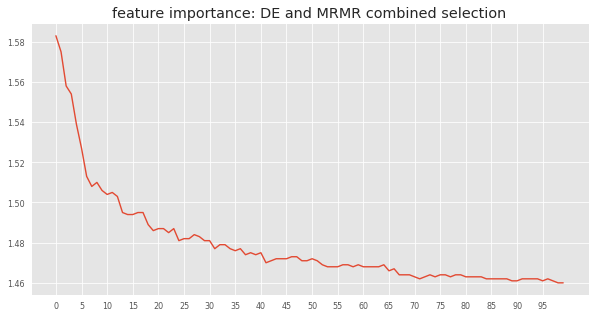

In [574]:
mrmrmixhcctable = get_featurename_mrmr(mixfeaturenamesplit[namefromde[2][0]][indfrommrmr[2][0]],coeffrommrmr[2][0])

,0,1,2,3,4
0,mRNA_ENSG00000163631.16: 1.584,mRNA_ABI2: 1.58,snoRNA_ENSG00000207047.2: 1.566,mRNA_MARCH9: 1.555,lncRNA_AL450311.2: 1.55
1,mRNA_NUFIP2: 1.551,lncRNA_AC159540.2: 1.535,tRNA_26038: 1.533,mRNA_LLGL2: 1.533,lncRNA_AL031282.2: 1.52
2,mRNA_PIEZO1: 1.521,mRNA_GPCPD1: 1.521,miRNA_MIR4419A: 1.522,mRNA_CBS: 1.514,mRNA_ASH1L: 1.516
3,mRNA_RICTOR: 1.514,mRNA_ECT2L: 1.516,mRNA_FOXN3: 1.51,lncRNA_LINC02227: 1.508,mRNA_USP8: 1.509
4,mRNA_AKT1: 1.505,mRNA_ARF3: 1.507,snoRNA_SNORD3A: 1.508,miRNA_MIR5696: 1.507,lncRNA_FTX: 1.508
5,mRNA_DSG2: 1.51,mRNA_CFL1: 1.51,miRNA_MIR6855: 1.504,miRNA_MIR641: 1.507,mRNA_OGT: 1.504
6,mRNA_SLC2A3: 1.502,mRNA_RPS14: 1.502,mRNA_DNTTIP2: 1.503,mRNA_MARF1: 1.501,mRNA_RPS23: 1.5
7,miRNA_MIR541: 1.498,lncRNA_AL138830.2: 1.498,lncRNA_PRAL: 1.498,mRNA_RUNX1: 1.498,snoRNA_SCARNA12: 1.497
8,mRNA_WWC1: 1.498,snoRNA_SNORD121A: 1.497,lncRNA_AP001496.2: 1.496,mRNA_SMIM8: 1.495,mRNA_DDX5: 1.496
9,mRNA_LRP8: 1.497,lncRNA_LINC00969: 1.497,lncRNA_AL033381.1: 1.496,mRNA_SRSF10: 1.497,snoRNA_ENSG00000200320.1: 1.496


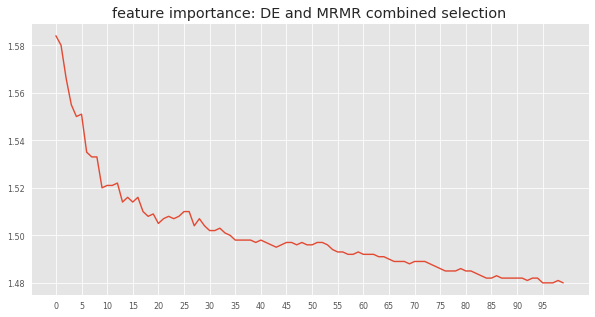

In [575]:
mrmrmixAtable = get_featurename_mrmr(mixfeaturenamesplit[namefromde[2][1]][indfrommrmr[2][1]],coeffrommrmr[2][1])

In [534]:
dataset[datatype[0]][dataclass[1]][:,namefromde[0][1][indfrommrmr[0][1]]]

array([[-1.21408135,  0.49192332, -0.72885701, ..., -0.58318068,
         0.20060743, -0.78649397],
       [ 0.75275604, -0.05438206,  0.40547713, ...,  0.75052451,
         2.82783846,  0.24004936],
       [-0.25114237, -0.68078831, -0.21106493, ..., -1.07944516,
         1.07249929, -0.68999183],
       ...,
       [-0.36362781, -0.54660193,  0.21291157, ..., -0.20518507,
         0.93298891, -0.51813762],
       [ 3.25480658,  0.75302577,  3.31039586, ...,  2.28744379,
         1.87604829,  1.47515718],
       [ 0.26508362,  0.72766953, -0.0071053 , ...,  0.33850141,
        -0.40413129, -0.75001122]])

##### 画logistic不同正则化参数的曲线和hist  smaller values specify stronger regularization.

In [55]:
penaltycoefresult = {}
penaltycoef = np.array([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5])
for i in range(penaltycoef.shape[0]):
    tmpcoef = logistic_selection(dataset['full']['A'],labelset['full']['A'],penalty=penaltycoef[i])
    penaltycoefresult[i] = tmpcoef[np.where(tmpcoef!=0)]
countlogshape = np.zeros([penaltycoef.shape[0]])
for i in range(penaltycoef.shape[0]):
    countlogshape[i] = penaltycoefresult[i].shape[0]

[Text(0,0,'0.2'),
 Text(0,0,'0.3'),
 Text(0,0,'0.4'),
 Text(0,0,'0.5'),
 Text(0,0,'0.6'),
 Text(0,0,'0.7'),
 Text(0,0,'0.8'),
 Text(0,0,'0.9'),
 Text(0,0,'1.0'),
 Text(0,0,'2.0'),
 Text(0,0,'3.0'),
 Text(0,0,'4.0'),
 Text(0,0,'5.0')]

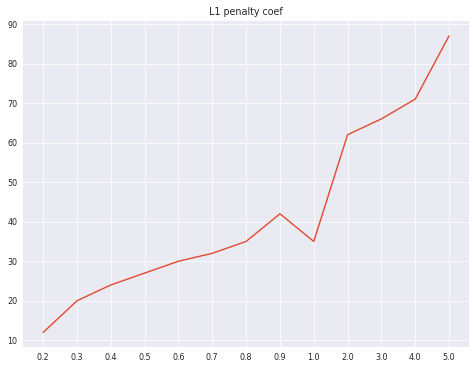

In [75]:
sns.set_context(contexts[0])
sns.set_style(styles[3])
fig,ax=plt.subplots(1,figsize=(8,6))
ax.plot(countlogshape)
ax.set_title('L1 penalty coef')
ax.set_xticks(range(penaltycoef.shape[0]))
ax.set_xticklabels(penaltycoef)

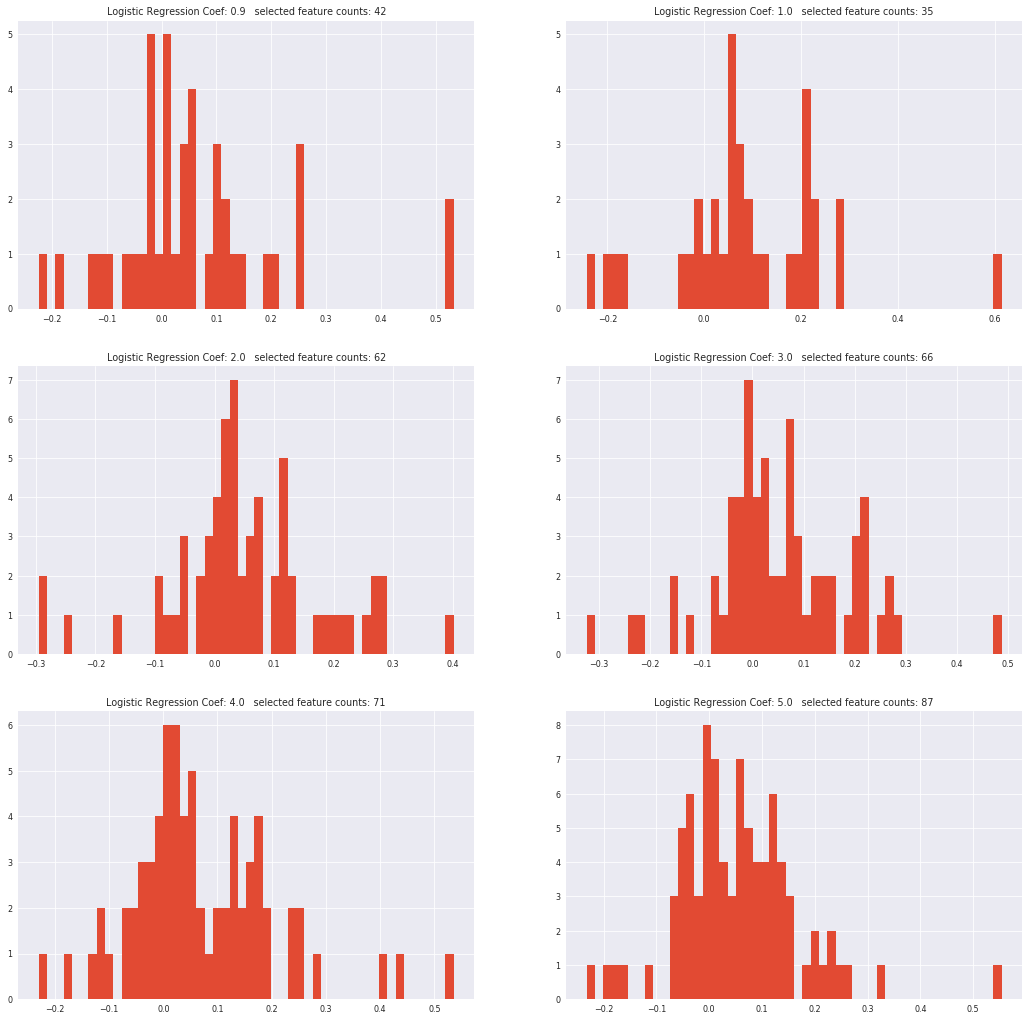

In [79]:
fig,ax=plt.subplots(3,2,figsize=(18,18))
for i in range(3):
    for j in range(2):
        ax[i,j].hist(penaltycoefresult[7+i*2+j],bins=50)
        ax[i,j].set_title('Logistic Regression Coef: '+str(penaltycoef[7+i*2+j])+'   selected feature counts: '+
                         str(penaltycoefresult[7+i*2+j].shape[0]))

### 验证特征选择的结果
- 做ROC
- PCA/tSNE

### 1，用logistic regression

Text(0.5,1,'Receiver operating characteristic example')

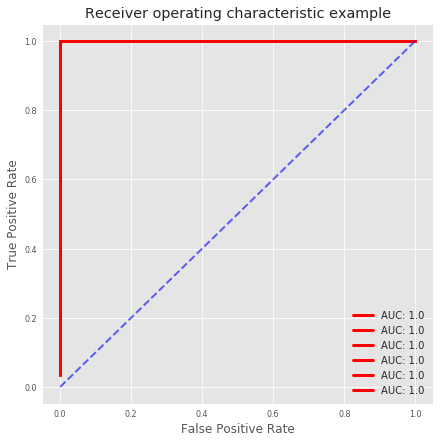

In [360]:
def logistic_roc(feature,label,penalty=2):
    logmodel = LogisticRegression(penalty='l1',C=penalty)
    y_score = logmodel.fit(feature,label).decision_function(feature)
    fpr, tpr, _ = roc_curve(label, y_score)
    roc_auc = auc(fpr, tpr)
    return roc_auc,fpr, tpr,logmodel.predict(feature)
roc,fpr,tpr,predict = {},{},{},{}
for i in range(3):
    for j in range(2):
        roc[i*2+j],fpr[i*2+j],tpr[i*2+j],predict[i*2+j]= \
        logistic_roc(dataset[datatype[i]][dataclass[j]],labelset[datatype[i]][dataclass[j]],penalty=2)
fig,ax=plt.subplots(1,figsize=(7,7))
for i in range(3):
    for j in range(2):
        ax.plot(fpr[i*2+j],tpr[i*2+j],linewidth=3,color='r',label='AUC: '+str(roc[i*2+j]))
ax.legend(prop={'size': 10})
ax.plot([0,1],[0,1], linewidth=2,alpha=0.6,color='b',linestyle='--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')

#### PCA and tSNE

In [356]:
def get_selected_feature(feature,label,method='log'):
    '''
    dataset[datatype[i]][dataclass[j]],labelset[datatype[i]][dataclass[j]]
    '''
    if method=='log':
        tmpfeaturecoef = logistic_selection(feature,label,penalty=2)
        tmpind = np.where(tmpfeaturecoef!=0)[0]
        return feature[:,tmpind]
    elif method=='tree':
        tmpfeaturecoef =get_feature_ind_tree(feature,label)
        tmpind = np.where(tmpfeaturecoef!=0)[0]
        return feature[:,tmpind]
    elif method=='mrmr':
        skip

In [169]:
get_selected_feature(dataset[datatype[i]][dataclass[j]],labelset[datatype[i]][dataclass[j]]).shape

(43, 96)

In [201]:
from sklearn.decomposition import PCA
def plot_PCA(data_whole,labels,title,dataclass='stage'):
    pca = PCA(n_components=2)
    pca.fit(data_whole+0.00001)
    x_2d = pca.transform(data_whole+0.00001)
    plt.figure(figsize=(10,8))
    if dataclass=='stage':
        labs = ['stageA','Normal']
    elif dataclass=='hcc':
        labs = ['HCC','Normal']
    for i, c, label in zip(np.arange(0,2), tableau20[:2], labs):
        plt.scatter(x_2d[labels == i, 0], x_2d[labels == i, 1], c=c, label=label,s=70)
    plt.legend(bbox_to_anchor=(1.3,0.55),fontsize=20)
    plt.title(title)
    plt.show()

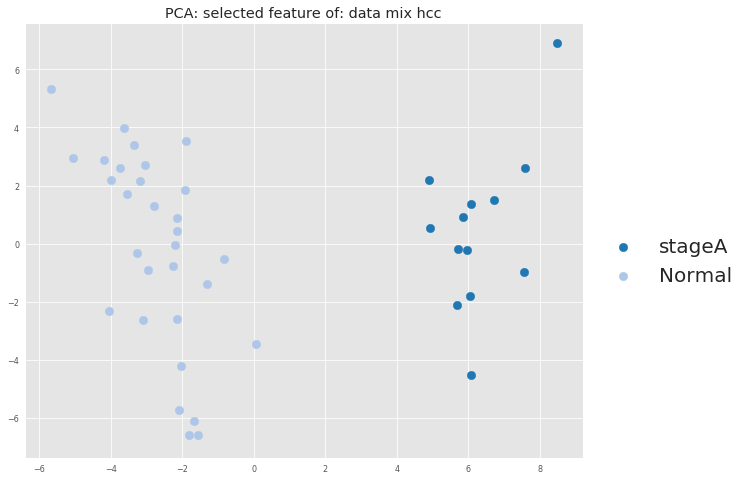

In [204]:
plot_PCA(get_selected_feature(dataset[datatype[i]][dataclass[j]],labelset[datatype[i]][dataclass[j]]),
         labelset[datatype[i]][dataclass[j]],'PCA: selected feature of: data '+datatype[i]+' '+dataclass[j],'stage')


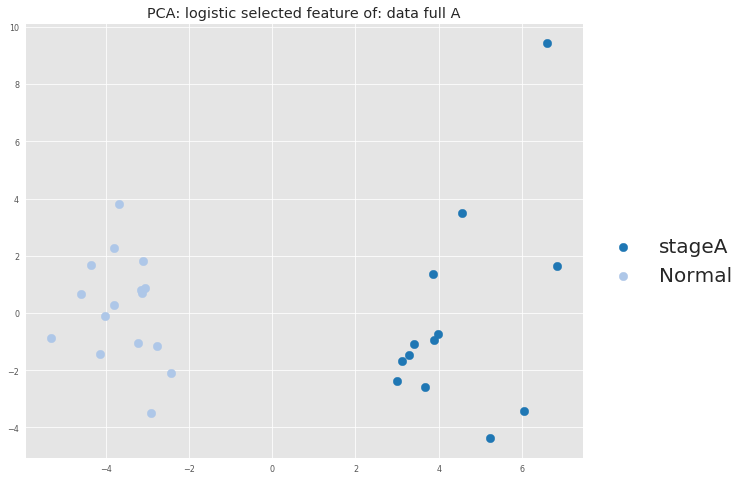

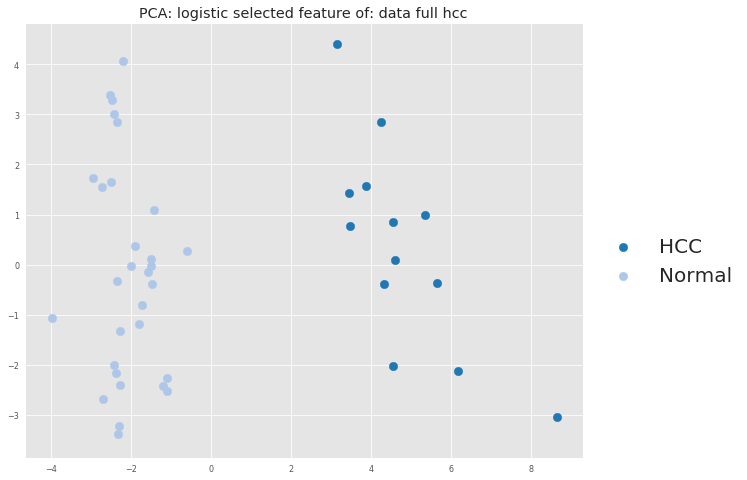

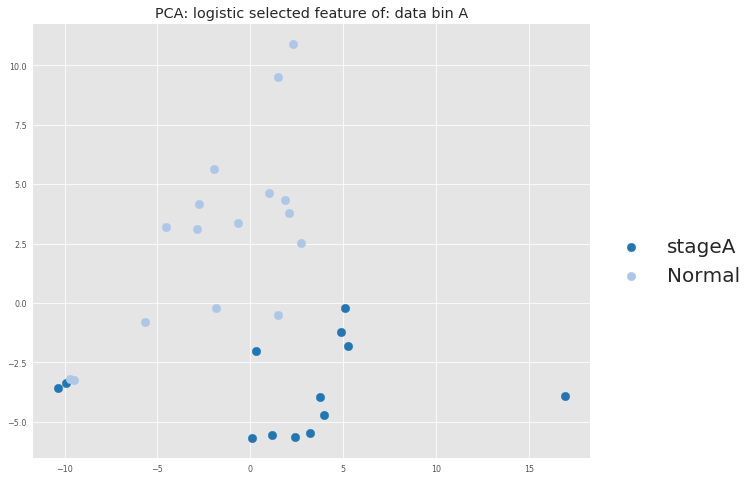

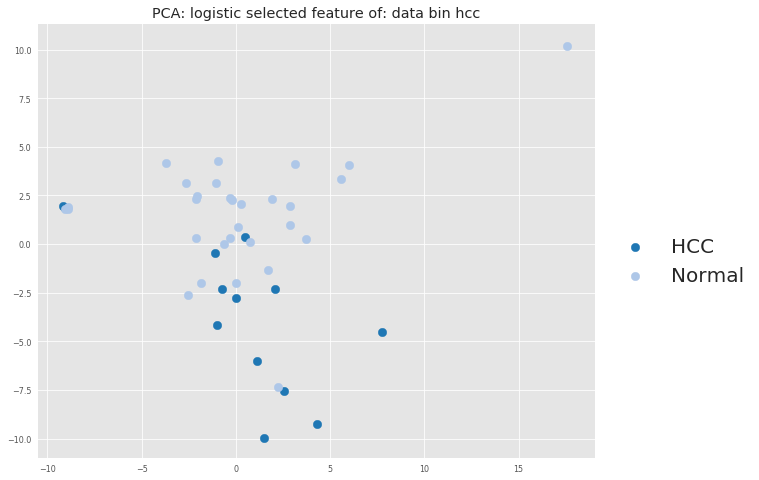

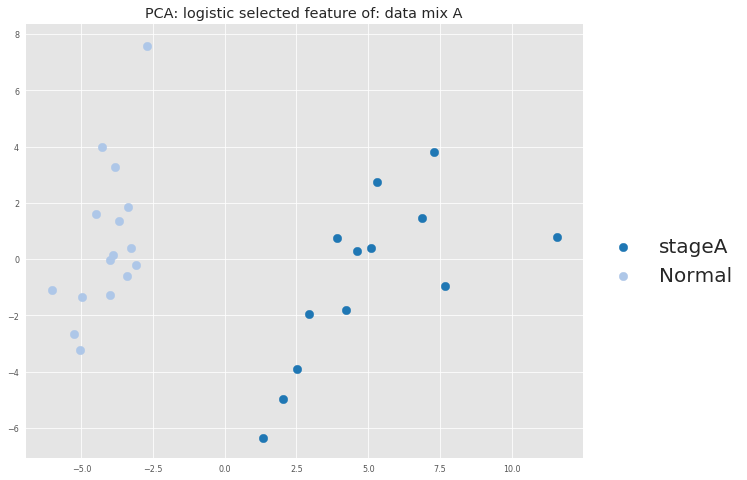

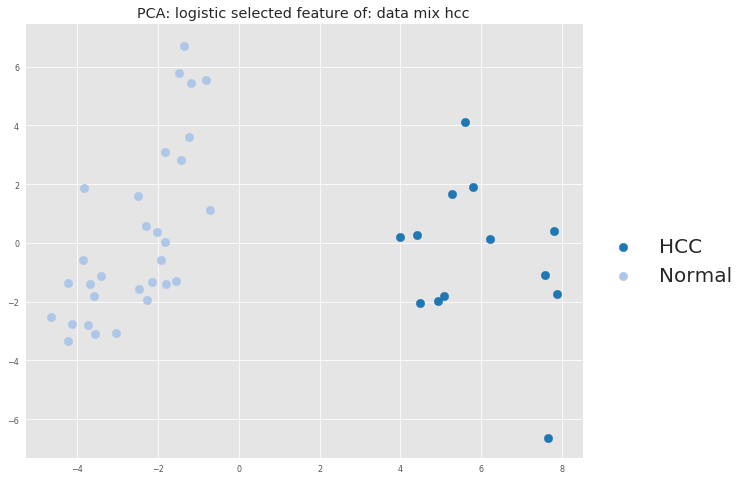

In [672]:
for i in range(3):
    for j in range(2):
        if not j%2:
            m='stage'
        else:
            m='hcc'
        plot_PCA(get_selected_feature(dataset[datatype[i]][dataclass[j]],labelset[datatype[i]][dataclass[j]]),
         labelset[datatype[i]][dataclass[j]],'PCA: logistic selected feature of: data '+datatype[i]+' '+dataclass[j],m)

In [541]:
from sklearn.manifold import TSNE
def plot_tsne(data_whole,labels,title,dataclass='stage'):
    tsne = TSNE(n_components=2, random_state=0)
    x_2d = tsne.fit_transform(data_whole)
    plt.figure(figsize=(10,8))
    if dataclass=='stage':
        labs = ['stageA','Normal']
    elif dataclass=='hcc':
        labs = ['HCC','Normal']
    for i, c, label in zip(np.arange(0,2), tableau20[:2], labs):
        plt.scatter(x_2d[labels == i, 0], x_2d[labels == i, 1], c=c, label=label,s=70)
    plt.legend(bbox_to_anchor=(1.3,0.55),fontsize=20)
    plt.title(title)
    plt.show()

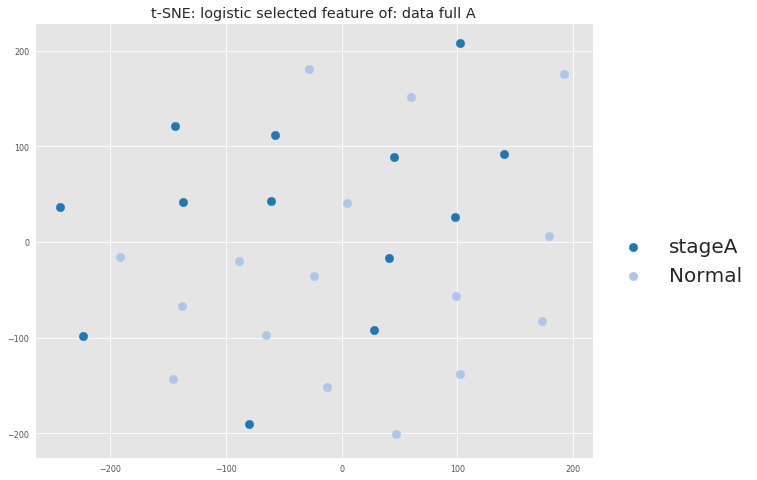

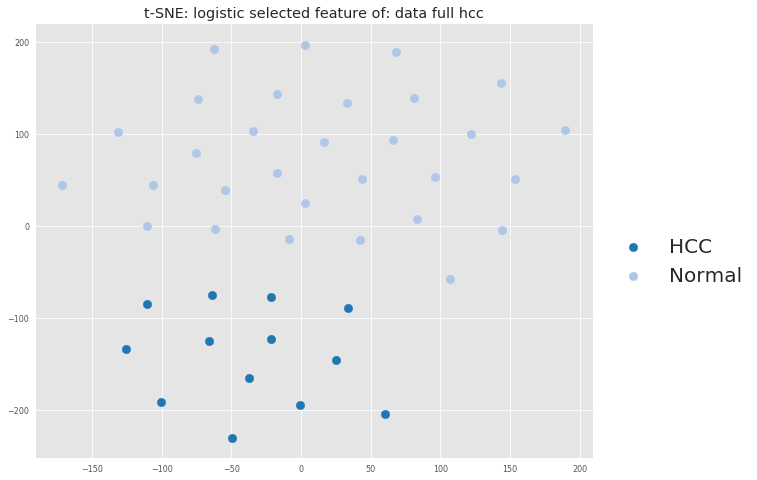

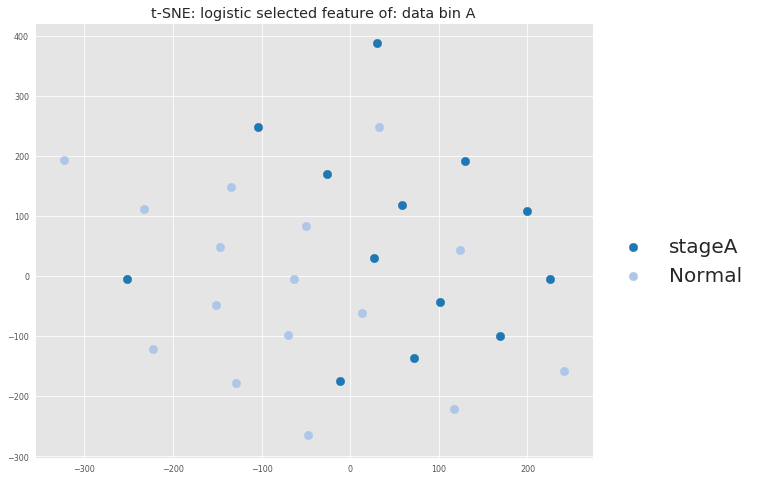

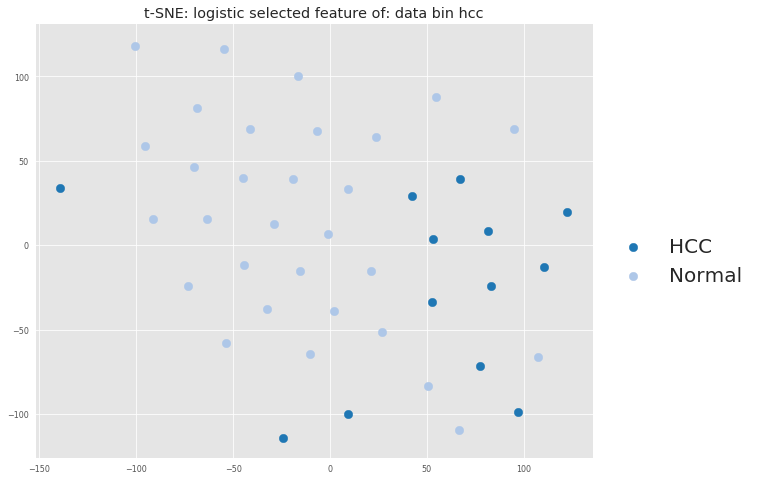

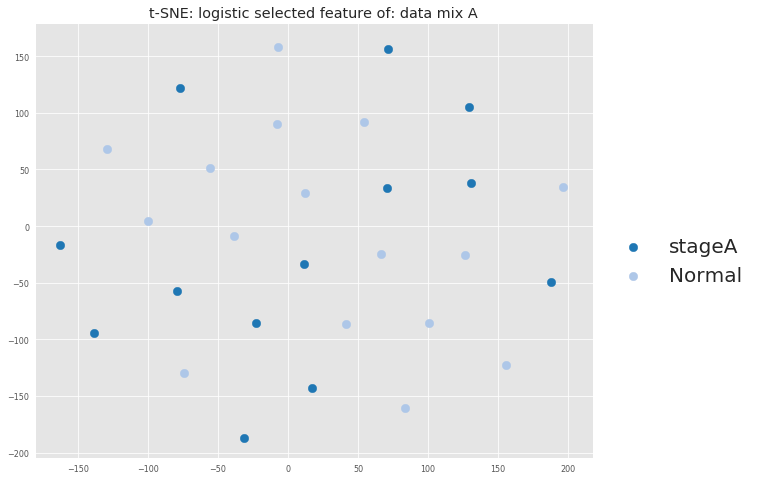

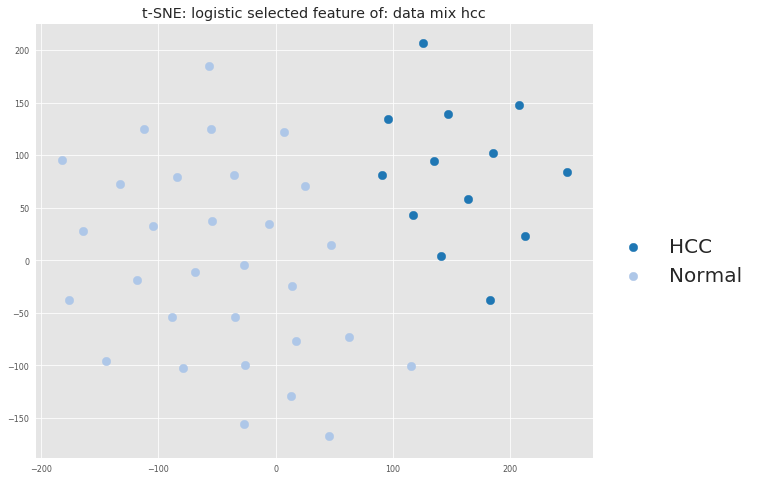

In [673]:
for i in range(3):
    for j in range(2):
        if not j%2:
            m='stage'
        else:
            m='hcc'
        plot_tsne(get_selected_feature(dataset[datatype[i]][dataclass[j]],labelset[datatype[i]][dataclass[j]]),
         labelset[datatype[i]][dataclass[j]],'t-SNE: logistic selected feature of: data '+datatype[i]+' '+dataclass[j],m)


### 2，用tree based

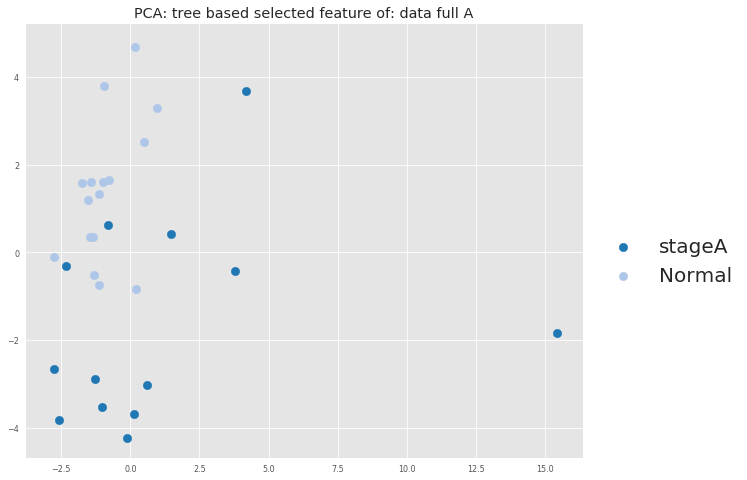

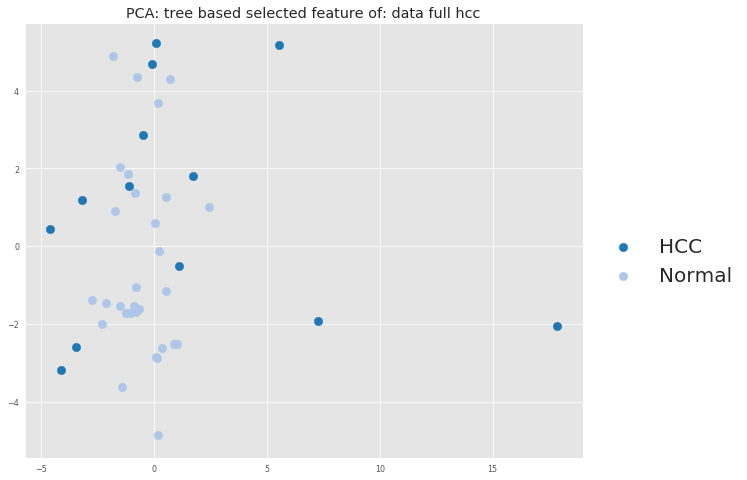

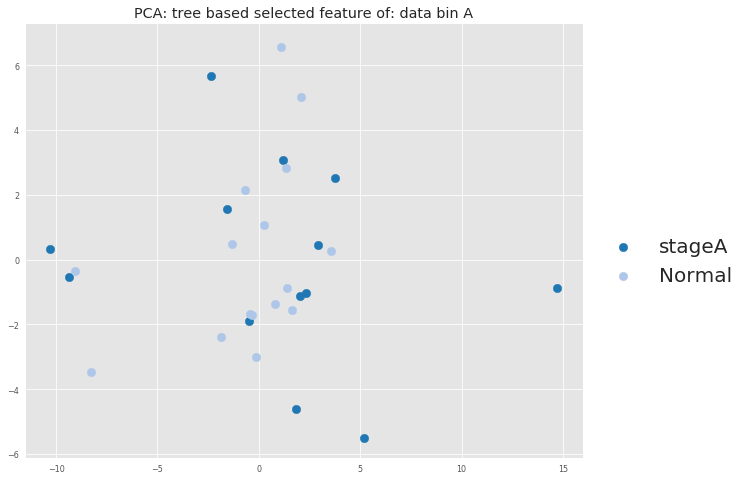

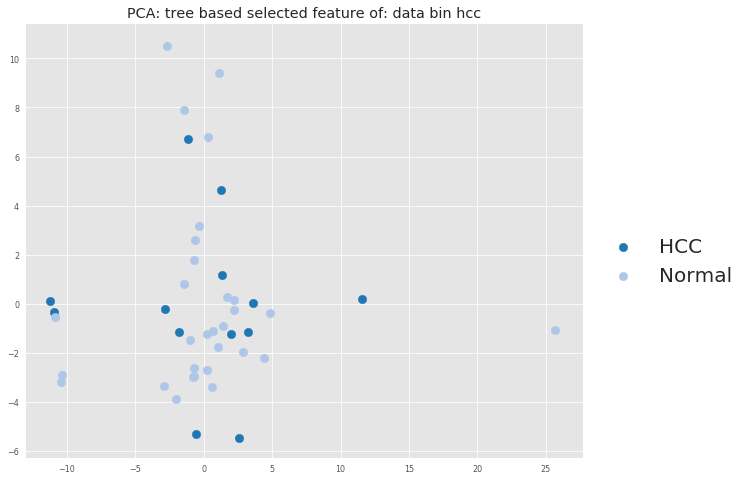

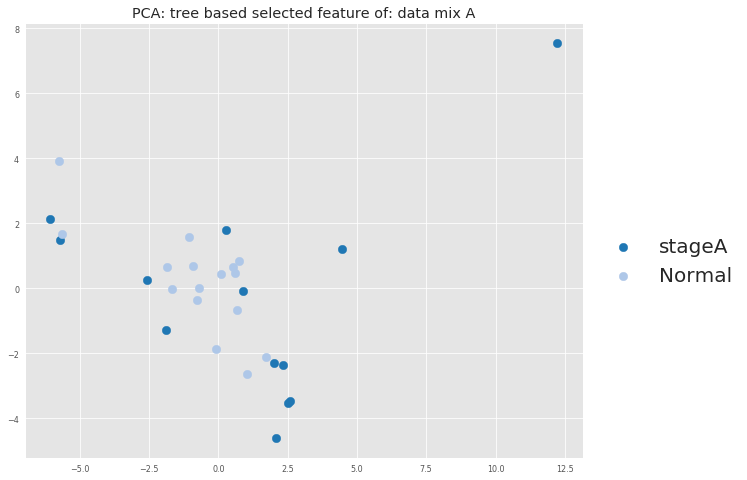

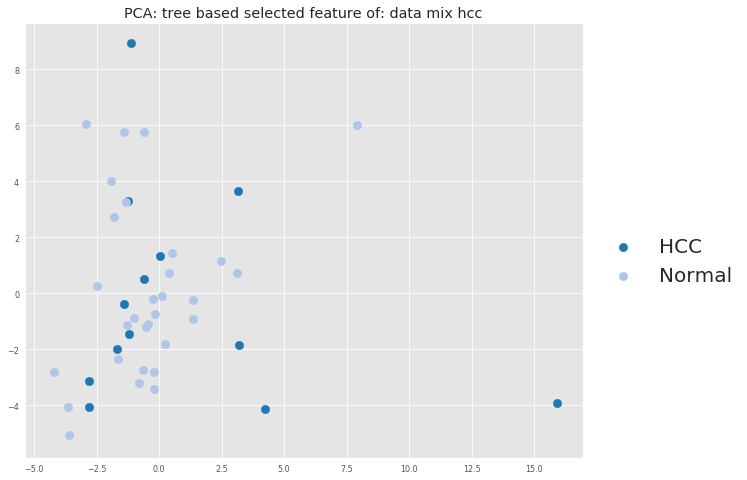

In [674]:
for i in range(3):
    for j in range(2):
        if not j%2:
            m='stage'
        else:
            m='hcc'
        plot_PCA(get_selected_feature(dataset[datatype[i]][dataclass[j]],labelset[datatype[i]][dataclass[j]],'tree'),
         labelset[datatype[i]][dataclass[j]],'PCA: tree based selected feature of: data '+datatype[i]+' '+dataclass[j],m)

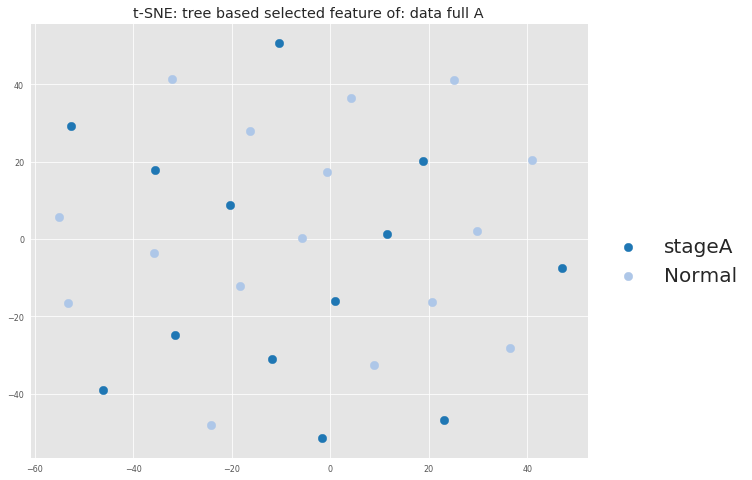

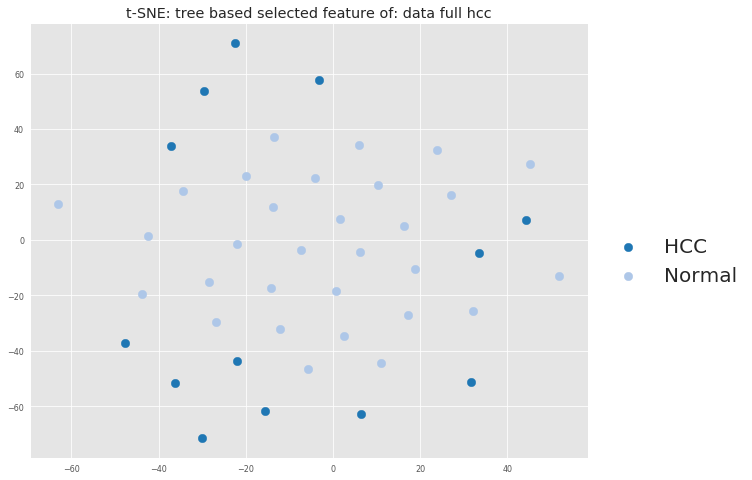

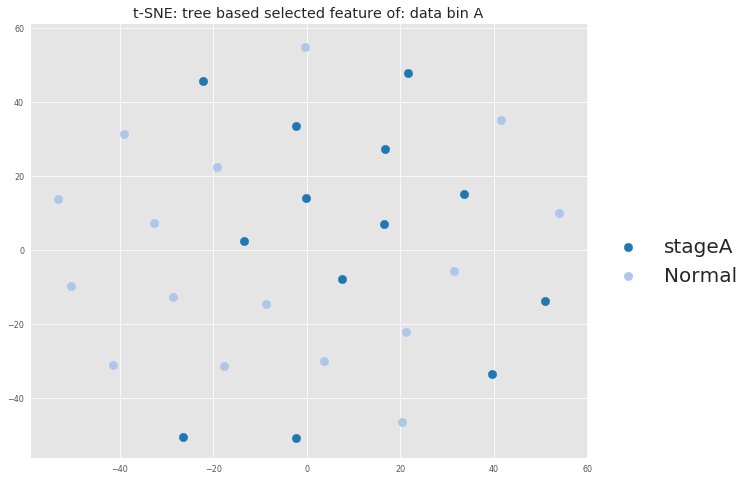

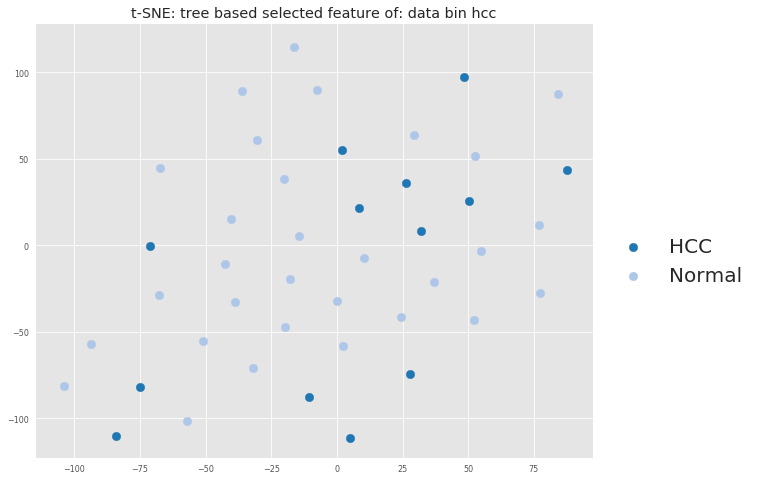

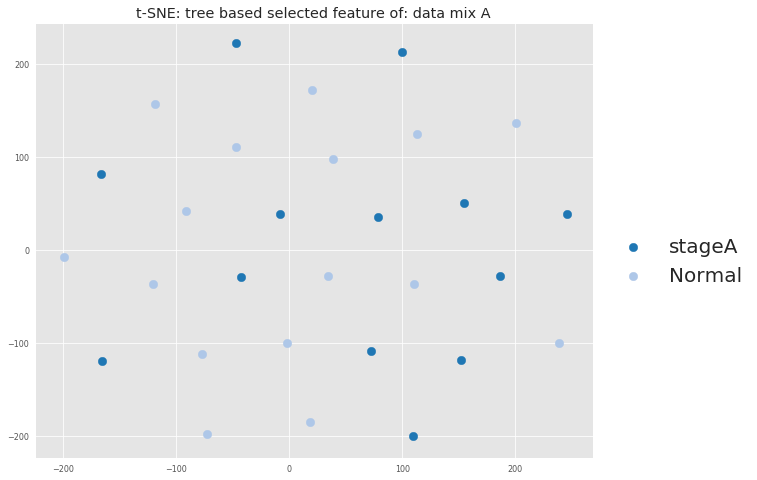

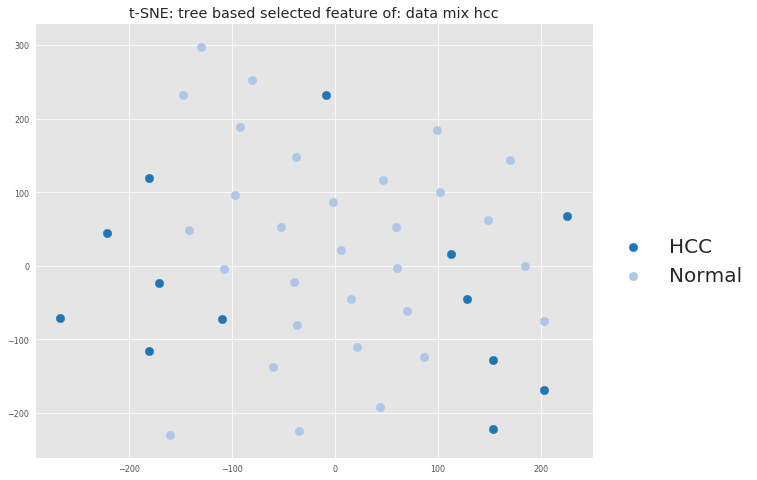

In [675]:
for i in range(3):
    for j in range(2):
        if not j%2:
            m='stage'
        else:
            m='hcc'
        plot_tsne(get_selected_feature(dataset[datatype[i]][dataclass[j]],labelset[datatype[i]][dataclass[j]],'tree'),
         labelset[datatype[i]][dataclass[j]],'t-SNE: tree based selected feature of: data '+datatype[i]+' '+dataclass[j],m)


In [361]:
get_selected_feature(dataset[datatype[i]][dataclass[j]],labelset[datatype[i]][dataclass[j]],'tree').shape

(43, 77)

Text(0.5,1,'Receiver operating characteristic example')

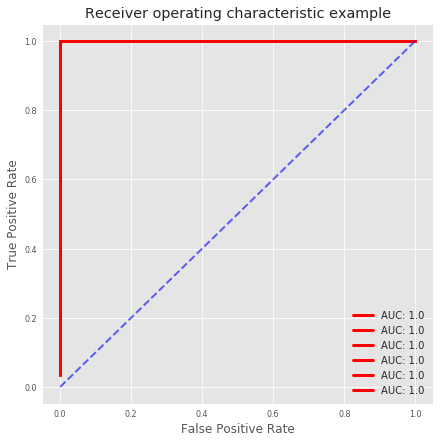

In [362]:
def tree_roc(feature,label,penalty=2):
    logmodel = LogisticRegression()
    y_score = logmodel.fit(feature,label).decision_function(feature)
    fpr, tpr, _ = roc_curve(label, y_score)
    roc_auc = auc(fpr, tpr)
    return roc_auc,fpr, tpr,logmodel.predict(feature)
roc,fpr,tpr,predict = {},{},{},{}
for i in range(3):
    for j in range(2):
        roc[i*2+j],fpr[i*2+j],tpr[i*2+j],predict[i*2+j]= \
        tree_roc(get_selected_feature(dataset[datatype[i]][dataclass[j]],labelset[datatype[i]][dataclass[j]],'tree'),labelset[datatype[i]][dataclass[j]])
fig,ax=plt.subplots(1,figsize=(7,7))
for i in range(3):
    for j in range(2):
        ax.plot(fpr[i*2+j],tpr[i*2+j],linewidth=3,color='r',label='AUC: '+str(roc[i*2+j]))
ax.legend(prop={'size': 10})
ax.plot([0,1],[0,1], linewidth=2,alpha=0.6,color='b',linestyle='--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')

### MRMR

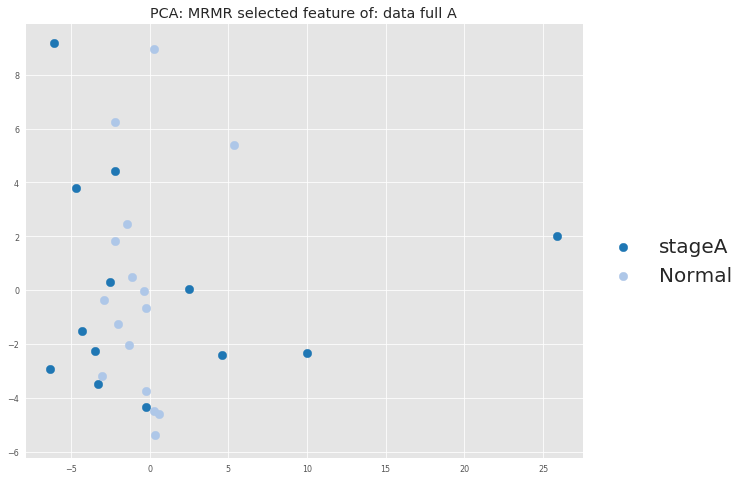

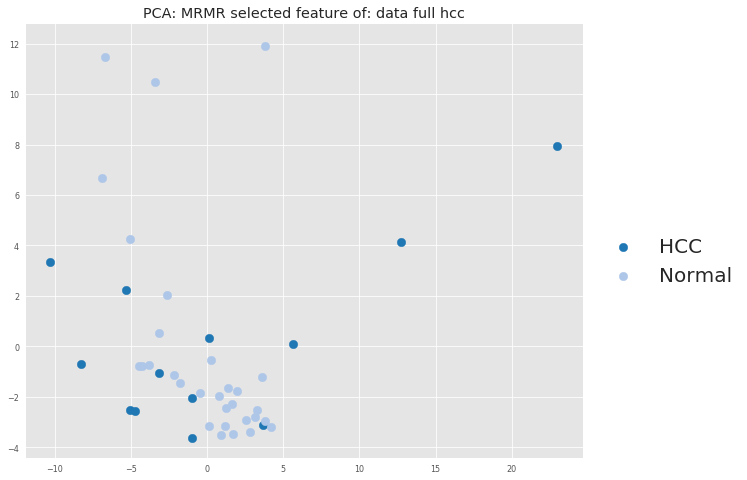

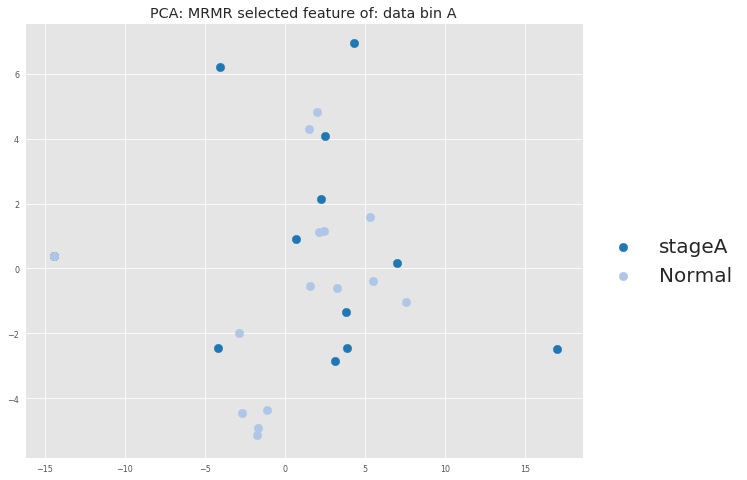

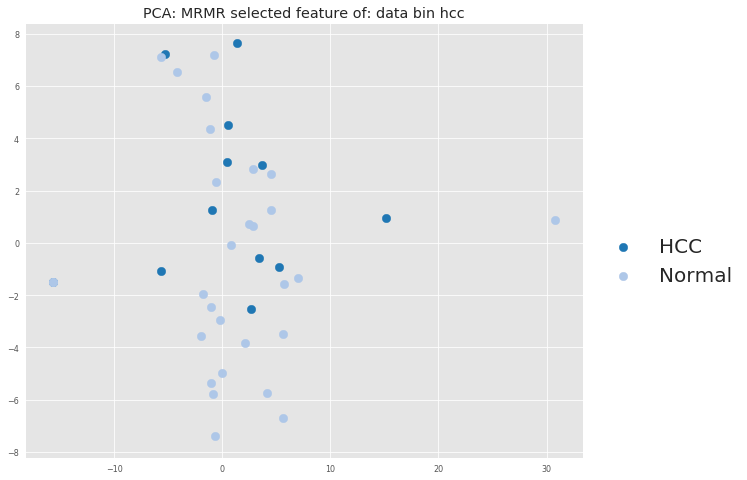

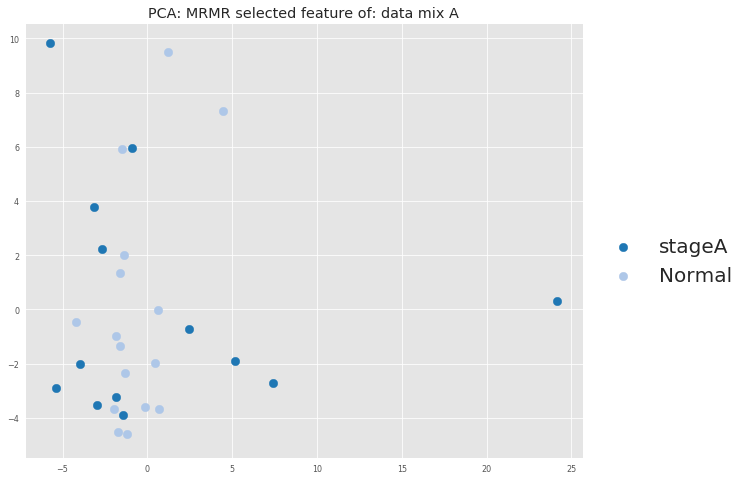

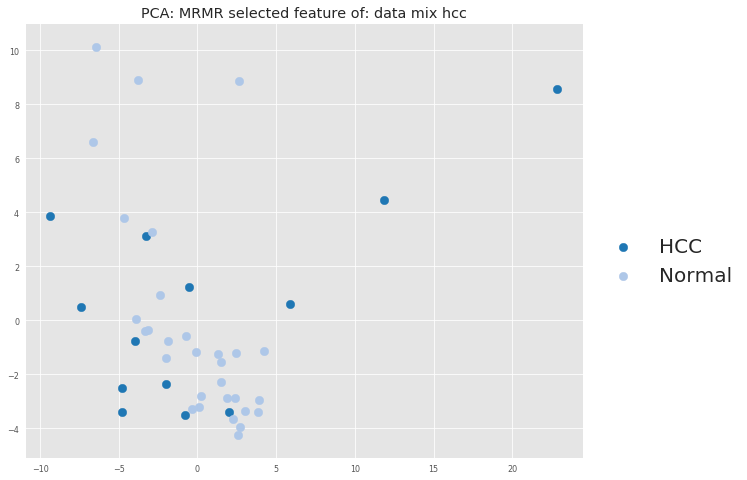

In [676]:
for i in range(3):
    for j in range(2):
        if not j%2:
            m='stage'
        else:
            m='hcc'
        plot_PCA(dataset[datatype[i]][dataclass[j]][:,namefromde[i][j][indfrommrmr[i][j]]],
         labelset[datatype[i]][dataclass[j]],'PCA: MRMR selected feature of: data '+datatype[i]+' '+dataclass[j],m)

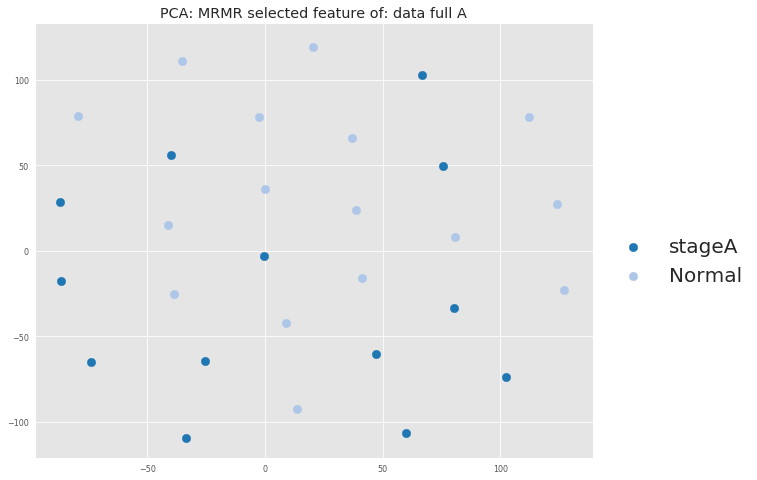

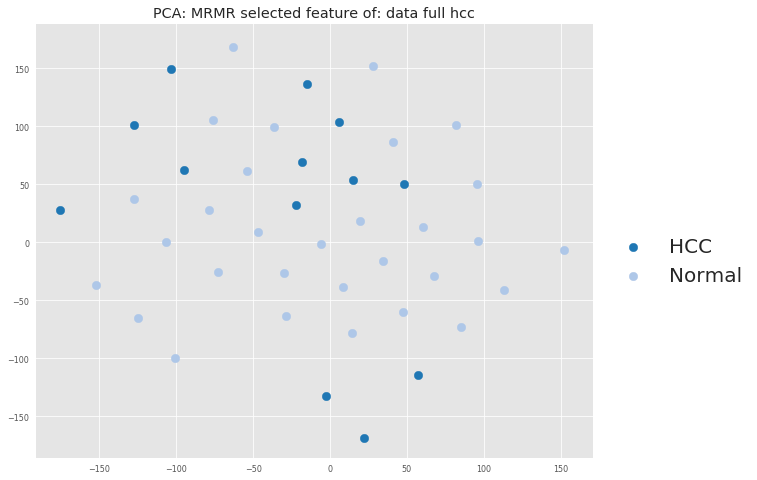

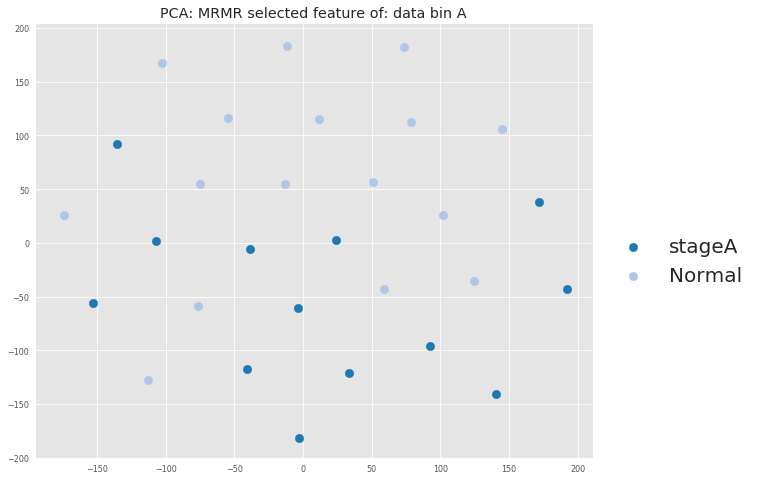

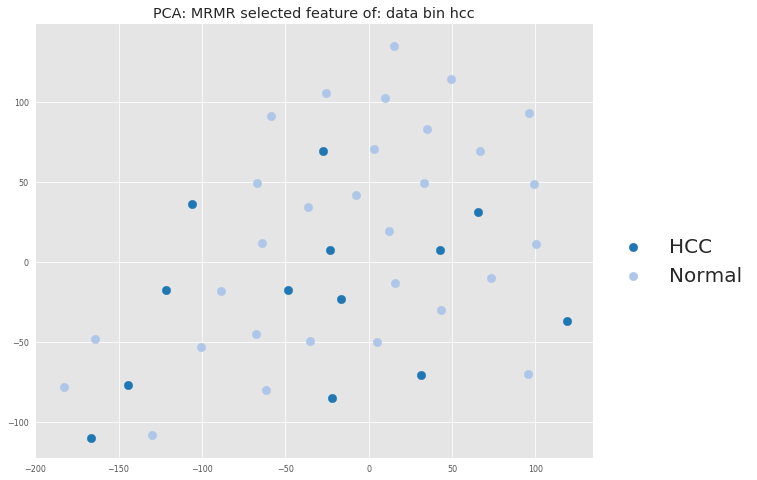

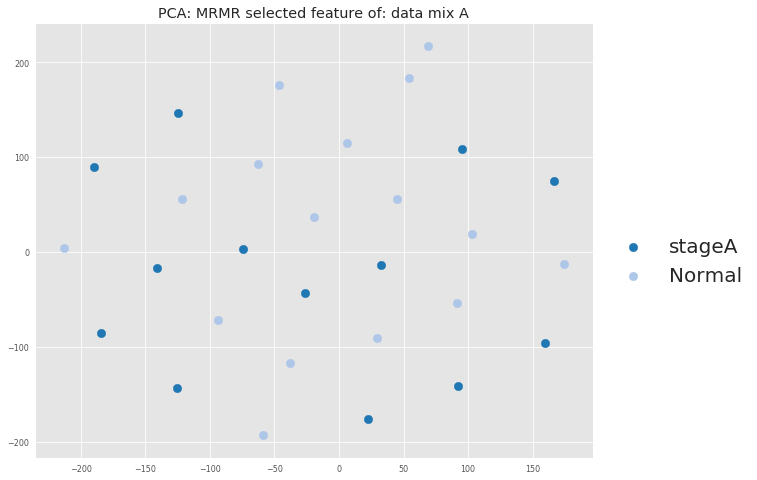

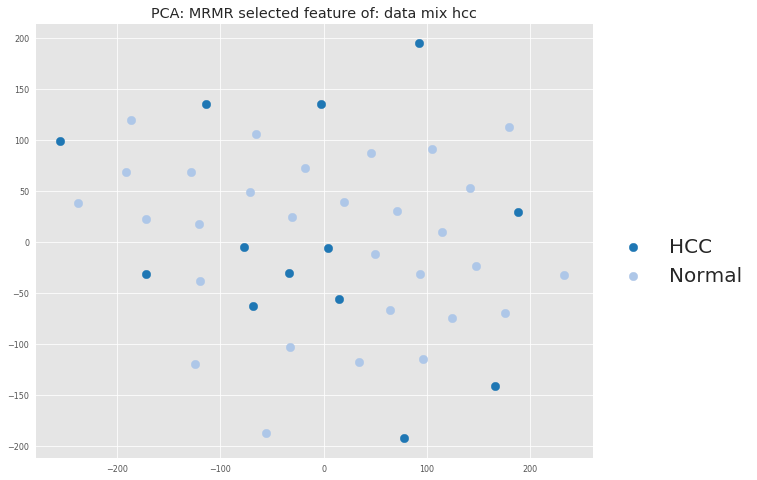

In [677]:
for i in range(3):
    for j in range(2):
        if not j%2:
            m='stage'
        else:
            m='hcc'
        plot_tsne(dataset[datatype[i]][dataclass[j]][:,namefromde[i][j][indfrommrmr[i][j]]],
         labelset[datatype[i]][dataclass[j]],'PCA: MRMR selected feature of: data '+datatype[i]+' '+dataclass[j],m)

Text(0.5,1,'Receiver operating characteristic example')

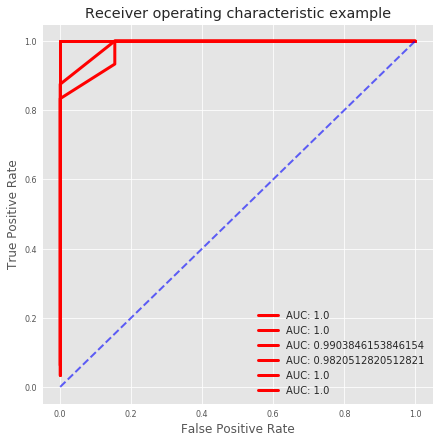

In [547]:
def mrmr_roc(feature,label,penalty=2):
    logmodel = LogisticRegression()
    y_score = logmodel.fit(feature,label).decision_function(feature)
    fpr, tpr, _ = roc_curve(label, y_score)
    roc_auc = auc(fpr, tpr)
    return roc_auc,fpr, tpr,logmodel.predict(feature)
roc,fpr,tpr,predict = {},{},{},{}
for i in range(3):
    for j in range(2):
        roc[i*2+j],fpr[i*2+j],tpr[i*2+j],predict[i*2+j]= \
        mrmr_roc(dataset[datatype[i]][dataclass[j]][:,namefromde[i][j][indfrommrmr[i][j]]],labelset[datatype[i]][dataclass[j]])
fig,ax=plt.subplots(1,figsize=(7,7))
for i in range(3):
    for j in range(2):
        ax.plot(fpr[i*2+j],tpr[i*2+j],linewidth=3,color='r',label='AUC: '+str(roc[i*2+j]))
ax.legend(prop={'size': 10})
ax.plot([0,1],[0,1], linewidth=2,alpha=0.6,color='b',linestyle='--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')

In [932]:
tableroc = pd.DataFrame(roctable,
             columns=['StageA vs Control','StageB vs Control','StageC vs Control'],
            index=['full','','','binned','','','mixed','','','miRNA','',''])

In [937]:
tableroc['cv'] = np.repeat(['cv1','cv2','cv3'],4).reshape(-1,4).T.ravel()

In [938]:
tableroc

,StageA vs Control,StageB vs Control,StageC vs Control,cv
full,0.850,0.650,0.633,cv1
,0.833,1.000,0.800,cv2
,0.500,1.000,1.000,cv3
binned,1.000,1.000,1.000,cv1
,1.000,0.917,1.000,cv2
,0.750,1.000,0.900,cv3
mixed,0.700,0.750,0.533,cv1
,1.000,0.917,0.750,cv2
,0.500,1.000,1.000,cv3
miRNA,0.850,0.500,0.700,cv1


In [577]:
mrmrmixAtable['ID']

0      mRNA_ENSG00000163631.16
1                    mRNA_ABI2
2     snoRNA_ENSG00000207047.2
3                  mRNA_MARCH9
4            lncRNA_AL450311.2
5                  mRNA_NUFIP2
6            lncRNA_AC159540.2
7                   tRNA_26038
8                   mRNA_LLGL2
9            lncRNA_AL031282.2
10                 mRNA_PIEZO1
11                 mRNA_GPCPD1
12              miRNA_MIR4419A
13                    mRNA_CBS
14                  mRNA_ASH1L
15                 mRNA_RICTOR
16                  mRNA_ECT2L
17                  mRNA_FOXN3
18            lncRNA_LINC02227
19                   mRNA_USP8
20                   mRNA_AKT1
21                   mRNA_ARF3
22              snoRNA_SNORD3A
23               miRNA_MIR5696
24                  lncRNA_FTX
25                   mRNA_DSG2
26                   mRNA_CFL1
27               miRNA_MIR6855
28                miRNA_MIR641
29                    mRNA_OGT
                ...           
70     mRNA_ENSG00000163631.16
71      

In [587]:
wholetables = [
logfullAtable,  treefullAtable,   mrmrfullAtable,
logfullhcctable,treefullhcctable, mrmrfullhcctable,
logbinAtable,   treebinAtable,    mrmrbinAtable,
logbinhcctable, treebinhcctable,  mrmrbinhcctable,
logmixAtable,   treemixAtable,    mrmrmixAtable,
logmixhcctable, treemixhcctable,  mrmrmixhcctable]

In [589]:
np.intersect1d(wholetables[0]['ID'],wholetables[1]['ID'])

array(['Y_RNA_ENSG00000201084.1', 'mRNA_FLYWCH1'], dtype=object)

In [591]:
np.intersect1d(wholetables[1]['ID'],wholetables[2]['ID'])

array(['mRNA_RBFOX2'], dtype=object)

In [592]:
np.intersect1d(wholetables[3]['ID'],wholetables[4]['ID'])

array(['mRNA_DMBT1'], dtype=object)

In [595]:
np.intersect1d(wholetables[6]['ID'],wholetables[7]['ID'])

array(['mRNA_ENSG00000156508.17', 'mRNA_RPS6', 'miRNA_MIR21',
       'miRNA_MIR486-2', 'miRNA_MIRLET7I', 'piRNA_piR.hsa.20572_3700',
       'snoRNA_SNORA73B'], dtype=object)

In [667]:
np.where(wholetables[6]['ID'] =='miRNA_MIR21')

(array([57, 90]),)

In [597]:
np.intersect1d(wholetables[7]['ID'],wholetables[8]['ID'])

array(['lncRNA_HELLPAR'], dtype=object)

In [598]:
np.intersect1d(wholetables[9]['ID'],wholetables[10]['ID'])

array(['Y_RNA_ENSG00000201778.1', 'lncRNA_AC023905.1',
       'mRNA_ENSG00000156508.17', 'miRNA_MIR486-2',
       'piRNA_piR.hsa.20572_3700', 'snoRNA_SNORD116.18',
       'srpRNA_RN7SL504P'], dtype=object)

In [599]:
np.intersect1d(wholetables[9]['ID'],wholetables[11]['ID'])

array(['lncRNA_AC006548.3', 'snoRNA_SNORD74B'], dtype=object)

In [600]:
np.intersect1d(wholetables[10]['ID'],wholetables[11]['ID'])

array(['lncRNA_HELLPAR', 'mRNA_ENSG00000127314.17',
       'mRNA_ENSG00000156265.15'], dtype=object)

In [601]:
np.intersect1d(wholetables[12]['ID'],wholetables[13]['ID'])

array(['Y_RNA_ENSG00000238783.1', 'mRNA_TLN2', 'piRNA_piR.hsa.20572_3700'],
      dtype=object)

In [603]:
np.intersect1d(wholetables[13]['ID'],wholetables[14]['ID'])

array(['mRNA_ARF3', 'mRNA_ENSG00000163631.16', 'mRNA_SOD2', 'tRNA_21363'],
      dtype=object)

In [604]:
np.intersect1d(wholetables[15]['ID'],wholetables[16]['ID'])

array(['piRNA_piR.hsa.1848_2'], dtype=object)

In [606]:
np.intersect1d(wholetables[16]['ID'],wholetables[17]['ID'])

array(['mRNA_ENSG00000156265.15'], dtype=object)

In [618]:
tmptable = wholetables[0]
for i in np.arange(1,18):
    tmptable = pd.concat((tmptable,wholetables[i]),axis=1)

In [619]:
tmptable.columns = ['fullA','logistic','fullA','tree','fullA','MRMR',
                   'fullhcc','logistic','fullhcc','tree','fullhcc','MRMR',
                   'binA','logistic','binA','tree','binlA','MRMR',
                   'binhcc','logistic','binhcc','tree','binhcc','MRMR',
                   'mixA','logistic','mixA','tree','mixA','MRMR',
                   'mixhcc','logistic','mixhcc','tree','mixhcc','MRMR',]

In [621]:
tmptable.to_csv('selected_feature_by_three_methods7.9.csv')

In [614]:
pd.concat((wholetables[0],wholetables[1]),axis=1).head()

,ID,importance,ID,importance
0,mRNA_C8orf59,0.554819,mRNA_ZNF711,0.0428994
1,mRNA_HRNR,0.467505,Y_RNA_ENSG00000206739.1,0.0383536
2,mRNA_TOM1L1,-0.323614,mRNA_SRP72,0.0379541
3,lncRNA_LINC01715,-0.287804,mRNA_LIG4,0.0284786
4,mRNA_SLC13A1,0.27939,piRNA_piR.hsa.23387_4612,0.0280477


In [622]:
tmptable_ = wholetables[0]['ID']
for i in np.arange(1,18):
    tmptable_ = pd.concat((tmptable_,wholetables[i]['ID']),axis=1)

In [624]:
tmptable_.columns = ['fullA: logistic','fullA: tree','fullA: MRMR',
                   'fullhcc: logistic','fullhcc: tree','fullhcc: MRMR',
                   'binA: logistic','binA: tree','binlA: MRMR',
                   'binhcc: logistic','binhcc: tree','binhcc: MRMR',
                   'mixA: logistic','mixA: tree','mixA: MRMR',
                   'mixhcc: logistic','mixhcc: tree','mixhcc: MRMR',]

In [625]:
tmptable_.to_csv('selected_feature_by_three_methods7.9_id.csv')

In [626]:
pwd

'/home/chenxupeng/projects/training'

In [641]:
nameforgene,countforgene = np.unique(tmparr,return_counts=True)

In [654]:
countforrepeat = countforgene[np.where(countforgene>2)][np.argsort(-countforgene[np.where(countforgene>2)])]

In [655]:
nameforrepeat = nameforgene[np.where(countforgene>2)][np.argsort(-countforgene[np.where(countforgene>2)])]

In [662]:
nameandcounttable = pd.DataFrame(np.concatenate((nameforrepeat.reshape(-1,1),
                            countforrepeat.reshape(-1,1)),axis=1),columns=['ID','Counts'])

In [ ]:
import gc, argparse, sys, os, errno
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from beakerx import *
plt.style.use('ggplot')
import seaborn as sns
sns.set()
import h5py
import os
from tqdm import tqdm
import scipy
import sklearn
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

In [666]:
pd.DataFrame(np.array(listnameandcount).reshape(-1,3)).to_csv('repeated_genes7.9.csv')

In [665]:
listnameandcount = []
for i in range(nameandcounttable.shape[0]):
    listnameandcount.append(nameandcounttable.iloc[i,0]+': '+str(nameandcounttable.iloc[i,1]))
display(pd.DataFrame(np.array(listnameandcount).reshape(-1,3)))

,0,1,2
0,piRNA_piR.hsa.20572_3700: 36,lncRNA_AC023905.1: 19,mRNA_ENSG00000156508.17: 17
1,mRNA_ENSG00000127314.17: 16,mRNA_FLYWCH1: 15,lncRNA_AC006548.3: 13
2,lncRNA_AC090340.1: 13,lncRNA_HELLPAR: 12,snoRNA_SNORD74B: 12
3,lncRNA_LINC00506: 10,mRNA_ENSG00000156265.15: 10,mRNA_RPS29: 10
4,mRNA_ENSG00000163631.16: 9,snoRNA_SNORA2B: 9,piRNA_piR.hsa.1848_2: 8
5,srpRNA_RN7SL504P: 7,lncRNA_FP236383.2: 7,miRNA_MIR486-2: 7
6,snoRNA_SNORD116.18: 6,lncRNA_AL360270.2: 6,lncRNA_LINC01427: 6
7,mRNA_ENSG00000166454.9: 6,lncRNA_ENSG00000226711.6: 6,lncRNA_ENSG00000234741.7: 6
8,lncRNA_ENSG00000259221.5: 6,mRNA_MBD3: 6,miRNA_MIR21: 6
9,miRNA_MIR122: 6,miRNA_MIRLET7I: 6,mRNA_SOD2: 5


In [637]:
tmparr = np.array(wholetables[0]['ID'])
for i in np.arange(1,18):
    tmparr = np.concatenate((tmparr,np.array(wholetables[i]['ID'])))